<a name='top'></a>
Javier Lopez<br>
Student ID: 000697446
# Model NYC Rideshare, Weather, Covid, and Vaccination Data
## Feb 2019-Mar 2022
***

>**Research Question 3:**
>
>Which predictive model and exogenous variables have the most impact on rideshare demand and forecasting?
***

In [1]:
import warnings
import calendar as cal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skm
from  sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.weightstats import ztest
from pmdarima.arima import auto_arima
from prophet import Prophet
from prophet.plot import plot_weekly
import xgboost as xgb
from xgboost import plot_importance
from scipy.stats import chisquare
%matplotlib inline
plt.rcParams['figure.figsize'] = (18,10)
plt.style.use('seaborn-whitegrid')
pd.set_option('mode.chained_assignment', None)
np.seterr(divide = 'ignore') 
warnings.filterwarnings('ignore')

## Load Data
***

In [2]:
data = pd.read_parquet('data/clean_data/model_dataset.parquet')

In [3]:
data.nyc.head(3)

uber      lyft  temp  prec  snow  case  hospitalized  death  \
2019-02-01  571535.0  197336.0  16.0   0.0   0.0   0.0           0.0    0.0   
2019-02-02  594632.0  193081.0  25.0   0.0   0.0   0.0           0.0    0.0   
2019-02-03  510417.0  174515.0  43.0   0.0   0.0   0.0           0.0    0.0   

            vaccination  phase_0  phase_1  phase_2  phase_3  
2019-02-01          0.0      1.0      0.0      0.0      0.0  
2019-02-02          0.0      1.0      0.0      0.0      0.0  
2019-02-03          0.0      1.0      0.0      0.0      0.0

In [4]:
uber = data.nyc[['uber']]
uber.name = 'uber'
weather = data.nyc[['temp', 'prec']]
covid = data.nyc[['case', 'hospitalized', 'death']]
vax = data.nyc[['vaccination']]

***
## Model Endogenous Variable: Rideshare Data <a name='0'/> 
***

### Data Preprocessing: Split Train/Test
***

In [5]:
def get_Xy_features(df):
    y = df.copy()
    X = pd.DataFrame(index=df.index)
    X['dayofweek'] = X.index.dayofweek
    X['quarter'] = X.index.quarter
    X['month'] = X.index.month
    X['year'] = X.index.year
    X['dayofyear'] = X.index.dayofyear
    X['dayofmonth'] = X.index.day
    X['weekofyear'] = X.index.weekofyear
    X[['phase_0', 'phase_1', 'phase_2', 'phase_3']] = data.nyc[['phase_0', 'phase_1', 'phase_2', 'phase_3']]
    
    holidays = ['2019/02/18', '2019/05/27', '2019/07/04', '2019/09/02', '2019/10/14', '2019/11/11', '2019/11/28', 
                '2019/12/25', '2020/01/01', '2020/01/20', '2020/02/17', '2020/05/25', '2020/07/03', '2020/07/04', 
                '2020/09/07', '2020/10/12', '2020/11/11', '2020/11/26', '2020/12/25', '2021/01/01', '2021/01/18', 
                '2021/02/15', '2021/05/31', '2021/06/18', '2021/06/19', '2021/07/04', '2021/07/05', '2021/09/06', 
                '2021/10/11', '2021/11/11', '2021/11/25', '2021/12/24', '2021/12/25', '2021/12/31', '2022/01/01',
                '2022/01/17', '2022/02/21']
    
    holiday = []
    for x in range(len(X)):
        if X.iloc[x].index.values[0] in holidays:
            holiday.append(1)
        else:
            holiday.append(0)
    X['holiday'] = holiday
        
    return X, y

In [6]:
X, y = get_Xy_features(uber)

In [7]:
X.head(3)

dayofweek  quarter  month  year  dayofyear  dayofmonth  \
2019-02-01          4        1      2  2019         32           1   
2019-02-02          5        1      2  2019         33           2   
2019-02-03          6        1      2  2019         34           3   

            weekofyear  phase_0  phase_1  phase_2  phase_3  holiday  
2019-02-01           5      1.0      0.0      0.0      0.0        0  
2019-02-02           5      1.0      0.0      0.0      0.0        0  
2019-02-03           5      1.0      0.0      0.0      0.0        0

In [8]:
y.head(3)

uber
2019-02-01  571535.0
2019-02-02  594632.0
2019-02-03  510417.0

In [9]:
chisquare(y[:'2021/04/30'])

Power_divergenceResult(statistic=array([45751619.92586423]), pvalue=array([0.]))

In [10]:
chisquare(y['2021/05/01':])

Power_divergenceResult(statistic=array([3001914.13334183]), pvalue=array([0.]))

In [11]:
def split_train_test(df, train_stop, test_start):
    train = df[:train_stop]
    test = df[test_start:]
    return train, test

In [12]:
train_stop = '2021/04/30'
test_start = '2021/05/01'

In [13]:
X_train, X_test = split_train_test(X, train_stop, test_start)
y_train, y_test = split_train_test(y, train_stop, test_start)

In [14]:
print('Train: %s observations from %s to %s' 
      %(len(y_train), 
        y_train.iloc[0].name.strftime('%m/%d/%Y'), 
        y_train.iloc[-1].name.strftime('%m/%d/%Y')))
print('Test: %s observation from %s to %s' 
      %(len(y_test), 
        y_test.iloc[0].name.strftime('%m/%d/%Y'), 
        y_test.iloc[-1].name.strftime('%m/%d/%Y')))

Train: 820 observations from 02/01/2019 to 04/30/2021
Test: 335 observation from 05/01/2021 to 03/31/2022


In [15]:
plt.subplot(211)
sns.lineplot(data=y_train.uber, label='Training Set')
sns.lineplot(data=y_test.uber, label= 'Testing Set')
plt.title('Uber Rideshare Demand in NYC')
plt.xlabel('Date')
plt.ylabel('Ride Count')
plt.show()

### Track Model Performance
***

In [16]:
def get_metrics(results, metrics, algo, name):
    expected = results.expected
    predicted = results.predicted
    metrics.loc[algo, name].rmse = np.round(skm.mean_squared_error(expected, predicted, squared=False), 2)
    metrics.loc[algo, name].mape = np.round(skm.mean_absolute_percentage_error(expected, predicted)*100, 2)
    metrics.loc[algo, name].z_score = np.round(ztest(expected, predicted)[0], 3)
    metrics.loc[algo, name].pvalue = ztest(expected, predicted)[1]
    metrics.loc[algo, name].observed_mean = np.round(expected.mean(), 2)
    metrics.loc[algo, name].forecast_mean = np.round(predicted.mean(), 2)
    metrics.loc[algo, name].observed_std = np.round(np.std(expected), 2)
    metrics.loc[algo, name].forecast_std = np.round(np.std(predicted), 2)
    return metrics

In [17]:
iterables = [['sarimax', 'prophet', 'xgboost'], 
             ['control', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6']]
index = pd.MultiIndex.from_product(iterables)
metrics = pd.DataFrame(index=index, 
                       columns=['rmse', 'mape', 'z_score', 'pvalue', 'observed_mean', 'forecast_mean', 'observed_std',
                                'forecast_std'])

In [18]:
metrics.head(3)

rmse mape z_score pvalue observed_mean forecast_mean  \
sarimax control  NaN  NaN     NaN    NaN           NaN           NaN   
        model_1  NaN  NaN     NaN    NaN           NaN           NaN   
        model_2  NaN  NaN     NaN    NaN           NaN           NaN   

                observed_std forecast_std  
sarimax control          NaN          NaN  
        model_1          NaN          NaN  
        model_2          NaN          NaN

### SARIMAX
***

#### Get Model Parameters
***

In [19]:
sarimax = auto_arima(y_train, exog=X_train, seasonal=True, m=7, trace=False, stepwise=True)

In [20]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  820
Model:             SARIMAX(5, 1, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -9563.822
Date:                                Thu, 11 Aug 2022   AIC                          19155.643
Time:                                        19:20:30   BIC                          19221.556
Sample:                                             0   HQIC                         19180.936
                                                - 820                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -231.1937    152.947     -1.512      0.131    -530.965      68.578
ar.L1          0.2040      0.313      0.652      0.514      -0.409       0.817
ar.L2         -0.1398      0.334     -0.418      0.676      -0.795       0.515
ar.L3         -0.5939      0.258     -2.299      0.022      -1.100      -0.087
ar.L4         -0.1188      0.035     -3.426      0.001      -0.187      -0.051
ar.L5         -0.1539      0.044     -3.490      0.000      -0.240      -0.067
ma.L1         -0.3501      0.315     -1.111      0.267      -0.968       0.268
ma.L2         -0.0199      0.378     -0.053      0.958      -0.761       0.721
ma.L3          0.5560      0.263      2.111      0.035       0.040       1.072
ar.S.L7        0.2779      0.568      0.489      0.625      -0.835       1.391
ar.S.L14       0.6983      0.559      1.248      0.212      -0.398       1.795
ma.S.L7       -0.1996      0.552     -0.361      0.718      -1.282       0.883
ma.S.L14      -0.6787      0.511     -1.328      0.184      -1.680       0.323
sigma2      8.666e+08   1.17e-05    7.4e+13      0.000    8.67e+08    8.67e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):               303.57
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.48e+30. Standard errors may be unstable.
"""

#### Train Model
***

In [21]:
mod = SARIMAX(y_train, exog=X_train, order=sarimax.order, seasonal_order=sarimax.seasonal_order, m=7).fit(disp=False)

In [22]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                   uber   No. Observations:                  820
Model:             SARIMAX(5, 1, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -9925.990
Date:                                Thu, 11 Aug 2022   AIC                          19901.979
Time:                                        19:20:43   BIC                          20019.681
Sample:                                    02-01-2019   HQIC                         19947.145
                                         - 04-30-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dayofweek   7888.1721    397.732     19.833      0.000    7108.632    8667.713
quarter    -1030.5187      0.903  -1141.539      0.000   -1032.288   -1028.749
month       9.149e+04      6.540    1.4e+04      0.000    9.15e+04    9.15e+04
year       -8.984e+04      0.323  -2.78e+05      0.000   -8.98e+04   -8.98e+04
dayofyear  -3157.8864    101.193    -31.207      0.000   -3356.221   -2959.552
dayofmonth  3170.5290    158.023     20.064      0.000    2860.809    3480.248
weekofyear -1046.3188    684.831     -1.528      0.127   -2388.564     295.926
phase_0     5412.4721      0.001   4.13e+06      0.000    5412.470    5412.475
phase_1    -1.263e+04      0.001  -2.22e+07      0.000   -1.26e+04   -1.26e+04
phase_2    -1.409e+04      0.001  -2.48e+07      0.000   -1.41e+04   -1.41e+04
phase_3     2.131e+04      0.000    5.1e+07      0.000    2.13e+04    2.13e+04
holiday             0     70.260          0      1.000    -137.708     137.708
ar.L1          0.0002      1.703      0.000      1.000      -3.338       3.339
ar.L2       8.621e-05      1.804   4.78e-05      1.000      -3.536       3.537
ar.L3         -0.0013      0.277     -0.005      0.996      -0.545       0.542
ar.L4         -0.0001      0.017     -0.008      0.993      -0.034       0.034
ar.L5          0.0003      0.005      0.058      0.954      -0.010       0.010
ma.L1      -9.788e-05      1.704  -5.75e-05      1.000      -3.339       3.339
ma.L2         -0.0006      1.804     -0.000      1.000      -3.537       3.536
ma.L3          0.0009      0.277      0.003      0.997      -0.542       0.544
ar.S.L7        0.2599      0.987      0.263      0.792      -1.675       2.195
ar.S.L14       0.6773      0.959      0.706      0.480      -1.203       2.557
ma.S.L7       -0.2593      0.987     -0.263      0.793      -2.193       1.675
ma.S.L14      -0.6771      0.958     -0.706      0.480      -2.556       1.201
sigma2      1.014e+09      0.001   1.01e+12      0.000    1.01e+09    1.01e+09
===================================================================================
Ljung-Box (L1) (Q):                   9.60   Jarque-Bera (JB):                88.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.27e+26. Standard errors may be unstable.
"""

In [23]:
fig = mod.plot_diagnostics()

#### Test Model
***

In [24]:
fcast = mod.get_forecast(exog=X_test, steps=len(y_test)).summary_frame()

In [25]:
fcast.head(3)

uber                 mean       mean_se  mean_ci_lower  mean_ci_upper
2021-05-01  377098.161067  31841.757089  314689.463968  439506.858165
2021-05-02  384222.599462  45032.887824  295959.761207  472485.437717
2021-05-03  336046.453887  55145.109077  227964.026172  444128.881602

In [26]:
sarimax_results = pd.concat([y_test, fcast], axis=1).dropna()
sarimax_results.mean_se = y_test.uber - sarimax_results['mean']
sarimax_res_cols = ['expected','predicted','error','lower','upper']
sarimax_results.columns = sarimax_res_cols

#### Plot Results
***

In [27]:
sarimax_results.head(3)

expected      predicted         error          lower  \
2021-05-01  377323.0  377098.161067    224.838933  314689.463968   
2021-05-02  324331.0  384222.599462 -59891.599462  295959.761207   
2021-05-03  295623.0  336046.453887 -40423.453887  227964.026172   

                    upper  
2021-05-01  439506.858165  
2021-05-02  472485.437717  
2021-05-03  444128.881602

In [28]:
def plot_results(results, model_name, train):
    fig, ax = plt.subplots(3,1)
    ax[0].plot(results[['expected','predicted']], label=['Expected','Predicted'])
    if 'lower' in results.columns and 'upper' in results.columns:
        ax[0].fill_between(results.index, results['lower'], results['upper'], 
                             color='k', alpha=0.1, label='Upper/Lower')
    ax[0].set_title('%s Predicted vs Expected - Jan-Mar 2022' %model_name)
    ax[0].set_ylabel('Ride Count')
    ax[0].grid(alpha=0.25)
    ax[0].legend()

    ax[1].plot(train, label='Training')
    ax[1].plot(results[['expected','predicted']], label=['Expected','Predicted'])
    if 'lower' in results.columns and 'upper' in results.columns:
        ax[1].fill_between(results.index, results['lower'], results['upper'], 
                             color='k', alpha=0.1, label='Upper/Lower')
    ax[1].set_title('%s Train, Test, Predict - Apr 2020-Mar 2022' %model_name)
    ax[1].set_ylabel('Ride Count')
    ax[1].grid(alpha=0.25)
    ax[1].legend()

    ax[2].plot(results.error)
    ax[2].set_title('Error')
    ax[2].set_xlabel('Date')
    ax[2].set_ylabel('Error')
    ax[2].grid(alpha=0.25)
    plt.tight_layout()

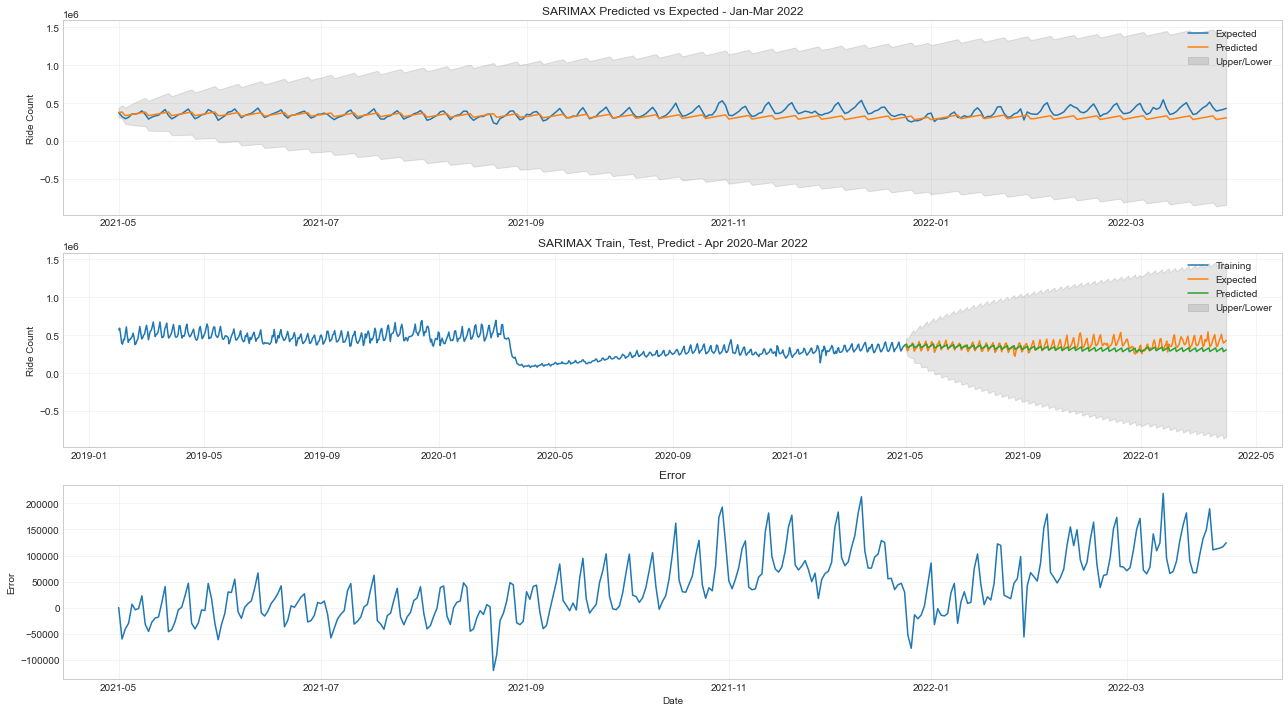

In [29]:
plot_results(sarimax_results, 'SARIMAX', y_train)

In [30]:
get_metrics(sarimax_results, metrics, 'sarimax', 'control').dropna()

rmse   mape z_score pvalue observed_mean forecast_mean  \
sarimax control  73182.06  13.99  12.236    0.0     370507.73     328625.19   

                observed_std forecast_std  
sarimax control     57620.28     24349.79

### Prophet <a name='16'/>
***

In [31]:
prophet_train = y_train.reset_index()
prophet_train.columns = ['ds', 'y']
prophet_train = pd.concat([prophet_train, X_train.reset_index(drop=True)], axis=1)
prophet_train.head(3)

ds         y  dayofweek  quarter  month  year  dayofyear  \
0 2019-02-01  571535.0          4        1      2  2019         32   
1 2019-02-02  594632.0          5        1      2  2019         33   
2 2019-02-03  510417.0          6        1      2  2019         34   

   dayofmonth  weekofyear  phase_0  phase_1  phase_2  phase_3  holiday  
0           1           5      1.0      0.0      0.0      0.0        0  
1           2           5      1.0      0.0      0.0      0.0        0  
2           3           5      1.0      0.0      0.0      0.0        0

In [32]:
prophet_test = y_test.reset_index()
prophet_test.columns = ['ds', 'y']
prophet_test = pd.concat([prophet_test, X_test.copy().reset_index(drop=True)], axis=1)
prophet_test.head(3)

ds         y  dayofweek  quarter  month  year  dayofyear  \
0 2021-05-01  377323.0          5        2      5  2021        121   
1 2021-05-02  324331.0          6        2      5  2021        122   
2 2021-05-03  295623.0          0        2      5  2021        123   

   dayofmonth  weekofyear  phase_0  phase_1  phase_2  phase_3  holiday  
0           1          17      0.0      0.0      0.0      1.0        0  
1           2          17      0.0      0.0      0.0      1.0        0  
2           3          18      0.0      0.0      0.0      1.0        0

#### Train Model
***

In [33]:
m = Prophet(daily_seasonality=7)

In [34]:
for col in X_train.columns:
    m.add_regressor(col)

In [35]:
m.fit(prophet_train)

Initial log joint probability = -21.9873
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1883.03     0.0077755       230.632           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1887.15   0.000205864       122.886      0.8934      0.8934      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       1887.53   0.000145262       138.169   9.331e-07       0.001      384  LS failed, Hessian reset 
     290        1887.6   0.000104028       75.8153   1.402e-06       0.001      451  LS failed, Hessian reset 
     299        1887.6   4.10126e-06       62.9336      0.4133           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     332       1887.61   1.60805e-05        89.375   2.121e-07       0.001      543  LS failed, Hessian rese

#### Test Model
***

In [36]:
future = m.make_future_dataframe(periods=len(prophet_test), freq='d')

In [37]:
regressors = pd.concat([X_train, X_test])
future = pd.concat([future, regressors.reset_index(drop=True)], axis=1)

In [38]:
future.head(3)

ds  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
0 2019-02-01          4        1      2  2019         32           1   
1 2019-02-02          5        1      2  2019         33           2   
2 2019-02-03          6        1      2  2019         34           3   

   weekofyear  phase_0  phase_1  phase_2  phase_3  holiday  
0           5      1.0      0.0      0.0      0.0        0  
1           5      1.0      0.0      0.0      0.0        0  
2           5      1.0      0.0      0.0      0.0        0

In [39]:
fcast = m.predict(future)

In [40]:
fcast = fcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')
fcast.index.name = None

In [41]:
fcast.head(3)

yhat     yhat_lower     yhat_upper
2019-02-01  552876.825856  500280.938997  608860.691040
2019-02-02  572041.605759  517153.379172  625091.500709
2019-02-03  508996.738937  453882.203135  557914.455242

In [42]:
prophet_results = pd.concat([y_test,fcast],axis=1)
prophet_results['error'] = y_test.uber - fcast.yhat

In [43]:
prophet_results.columns = ['expected', 'predicted', 'lower', 'upper', 'error']
prophet_results = prophet_results[['expected', 'predicted', 'error', 'lower', 'upper']]

In [44]:
prophet_results = prophet_results[test_start:]

#### Plot Results
***

In [45]:
prophet_results.head(3)

expected      predicted         error          lower  \
2021-05-01  377323.0  420142.723013 -42819.723013  366334.209140   
2021-05-02  324331.0  359762.771416 -35431.771416  305253.064901   
2021-05-03  295623.0  311225.232146 -15602.232146  258193.838113   

                    upper  
2021-05-01  475305.269247  
2021-05-02  414129.458420  
2021-05-03  366986.901606

In [46]:
plot_results(prophet_results, 'Prophet', y_train)

In [47]:
get_metrics(prophet_results, metrics, 'prophet', 'control').dropna()

rmse   mape z_score    pvalue observed_mean  \
sarimax control  73182.06  13.99  12.236       0.0     370507.73   
prophet control  39541.93   8.07   4.826  0.000001     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
prophet control     350029.01     57620.28      51899.0

### XGBoost
***

#### Data Preprocessing
***

In [48]:
(X_train_scaler, X_test_scaler, y_train_scaler, y_test_scaler) = (MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), 
                                                                  MinMaxScaler())


In [49]:
X_train_scaled = pd.DataFrame(X_train_scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaler.fit_transform(X_test), index=X_test.index, columns=X_test.columns)
y_train_scaled = pd.DataFrame(y_train_scaler.fit_transform(y_train), index=y_train.index, columns=y_train.columns)
y_test_scaled = pd.DataFrame(y_test_scaler.fit_transform(y_test), index=y_test.index, columns=y_test.columns)

#### Train Model
***

In [50]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [51]:
reg.fit(X_train_scaled, y_train_scaled, eval_set=[(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)], 
        early_stopping_rounds=50, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

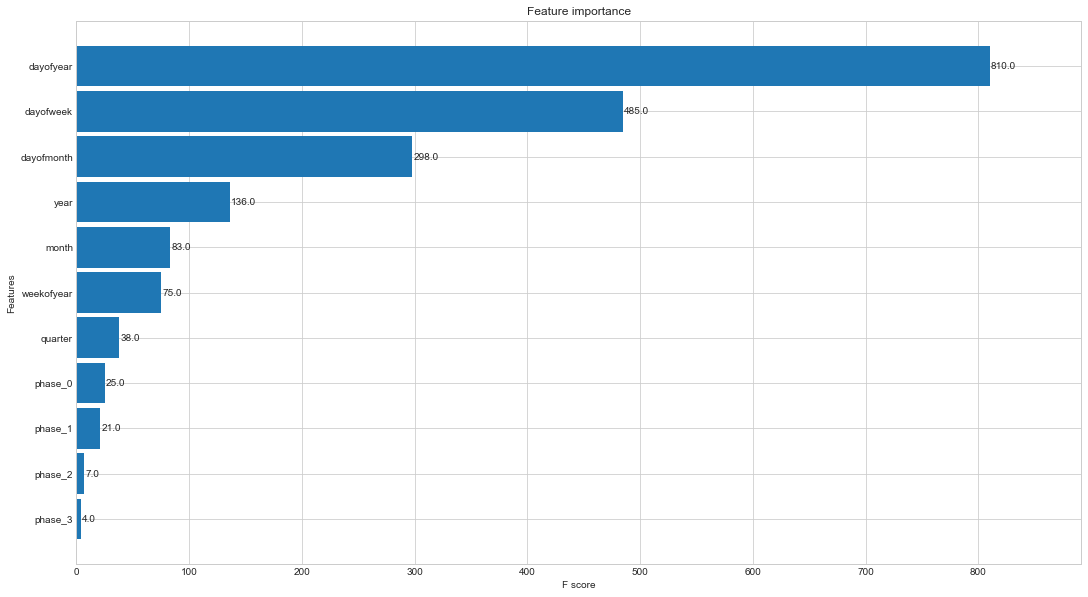

In [52]:
_ = plot_importance(reg, height=0.9)
plt.show()

#### Test Model
***

In [53]:
preds = reg.predict(X_test_scaled)

In [54]:
inverse_preds = y_test_scaler.inverse_transform(pd.DataFrame(preds))

In [55]:
xgb_results = pd.DataFrame(y_test.values, index=y_test.index, columns=['expected'])
xgb_results['predicted'] = pd.DataFrame(inverse_preds)[0].values
xgb_results['error'] = xgb_results.expected - xgb_results.predicted

#### Plot Results
***

In [56]:
xgb_results.head(3)

expected     predicted        error
2021-05-01  377323.0  382517.78125  -5194.78125
2021-05-02  324331.0  376637.31250 -52306.31250
2021-05-03  295623.0  381719.84375 -86096.84375

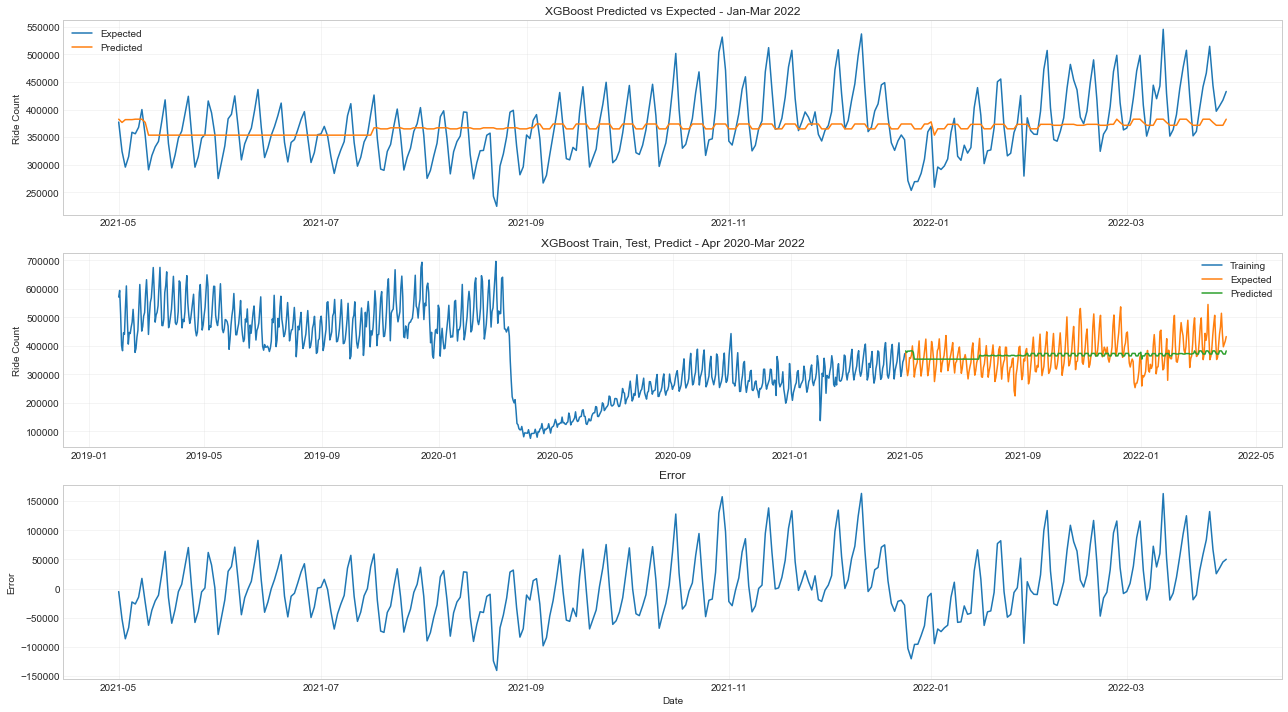

In [57]:
plot_results(xgb_results, 'XGBoost', y_train)

In [58]:
get_metrics(xgb_results, metrics, 'xgboost', 'control').dropna()

rmse   mape z_score    pvalue observed_mean  \
sarimax control  73182.06  13.99  12.236       0.0     370507.73   
prophet control  39541.93   8.07   4.826  0.000001     370507.73   
xgboost control  54352.91   11.5   1.051  0.293268     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
prophet control     350029.01     57620.28      51899.0  
xgboost control     367160.06     57620.28      8344.25

***
## Model with Exogenous Variables: Covid Cases, Weather, Competitor Rides
***

### Data Preprocessing: Split Train/Test
***

In [59]:
temp = weather.temp
prec = weather.prec
cases = covid.case
hosp = covid.hospitalized
death = covid.death
vax = vax.vaccination

In [60]:
temp_train, temp_test = split_train_test(temp, train_stop, test_start)
prec_train, prec_test = split_train_test(prec, train_stop, test_start)
cases_train, cases_test = split_train_test(cases, train_stop, test_start)
hosp_train, hosp_test = split_train_test(hosp, train_stop, test_start)
death_train, death_test = split_train_test(death, train_stop, test_start)
vax_train, vax_test = split_train_test(vax, train_stop, test_start)

## Compare Model Performance
***

>Models:
>* **Model 1:** Weather, Temperature
>* **Model 2:** Weather, Precipitation
>* **Model 3:** Covid-19, Cases
>* **Model 4:** Covid-19, Hospitalizations
>* **Model 5:** Covid-19, Deaths
>* **Model 6:** Covid-19, Vaccinations

### SARIMAX <a name='37'/>
***

In [61]:
def get_sarimax(y_train, y_test, X_train, X_test):
    # Get model parameters
    sarimax = auto_arima(y_train, exog=X_train, seasonal=True, m=7, trace=False, stepwise=True)  
    # Train model
    mod = SARIMAX(y_train, exog=X_train, order=sarimax.order, 
                  seasonal_order=sarimax.seasonal_order, m=7).fit(disp=False)   
    # View model summary
    display(mod.summary())  
    # View model diagnostics
    display(ax = mod.plot_diagnostics())
    plt.show()
    # Test model
    fcast = mod.get_forecast(exog=X_test, steps=len(y_test)).summary_frame()
    # Create dataframe from results
    sarimax_results = pd.concat([y_test, fcast], axis=1).dropna()
    sarimax_results.mean_se = y_test.uber - sarimax_results['mean']
    sarimax_res_cols = ['expected','predicted','error','lower','upper']
    sarimax_results.columns = sarimax_res_cols
    # Display results
    display(sarimax_results.head(3))
    # Plot results
    plot_results(sarimax_results, 'SARIMAX', y_train)
    plt.show()
    # Return results
    return sarimax_results

#### SARIMAX Model 1: Weather, Temperature
***

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                   uber   No. Observations:                  820
Model:             SARIMAX(5, 1, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -9919.230
Date:                                Thu, 11 Aug 2022   AIC                          19890.459
Time:                                        19:22:48   BIC                          20012.869
Sample:                                    02-01-2019   HQIC                         19937.432
                                         - 04-30-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dayofweek   7868.2345    368.119     21.374      0.000    7146.735    8589.734
quarter    -2462.5005      0.682  -3609.869      0.000   -2463.838   -2461.164
month       9.471e+04      6.595   1.44e+04      0.000    9.47e+04    9.47e+04
year        -7.19e+04        nan        nan        nan         nan         nan
dayofyear  -3195.4243     95.980    -33.293      0.000   -3383.542   -3007.307
dayofmonth  3279.4776    161.902     20.256      0.000    2962.156    3596.799
weekofyear -1046.2143    626.289     -1.670      0.095   -2273.717     181.289
phase_0       1.2e+04        nan        nan        nan         nan         nan
phase_1    -1.244e+04      0.000  -3.05e+07      0.000   -1.24e+04   -1.24e+04
phase_2    -1.596e+04        nan        nan        nan         nan         nan
phase_3     1.639e+04        nan        nan        nan         nan         nan
holiday             0     33.125          0      1.000     -64.924      64.924
temp        -667.9738    150.108     -4.450      0.000    -962.180    -373.768
ar.L1          0.0002      2.251   8.87e-05      1.000      -4.412       4.412
ar.L2       7.831e-05      2.168   3.61e-05      1.000      -4.249       4.249
ar.L3         -0.0017      0.409     -0.004      0.997      -0.804       0.800
ar.L4         -0.0002      0.010     -0.017      0.987      -0.020       0.019
ar.L5          0.0003      0.004      0.075      0.940      -0.008       0.008
ma.L1      -6.146e-05      2.251  -2.73e-05      1.000      -4.412       4.412
ma.L2         -0.0006      2.168     -0.000      1.000      -4.250       4.249
ma.L3          0.0013      0.409      0.003      0.997      -0.801       0.804
ar.S.L7        0.2501      1.066      0.235      0.815      -1.840       2.340
ar.S.L14       0.6877      1.035      0.665      0.506      -1.341       2.716
ma.S.L7       -0.2494      1.066     -0.234      0.815      -2.338       1.839
ma.S.L14      -0.6874      1.034     -0.665      0.506      -2.714       1.339
sigma2      1.007e+09        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                  10.57   Jarque-Bera (JB):                86.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.01e+26. Standard errors may be unstable.
"""

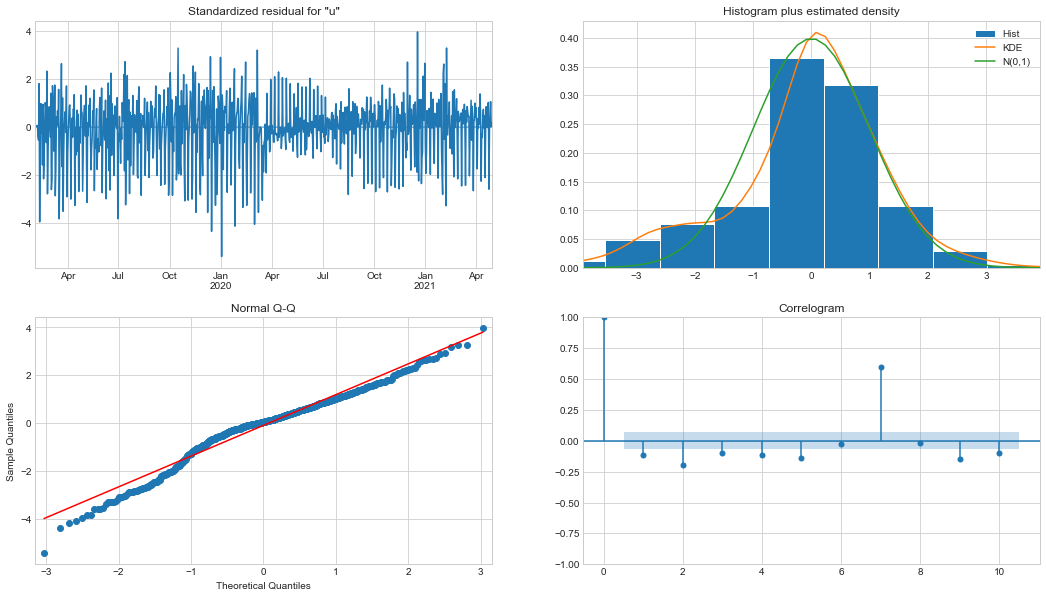

expected      predicted         error          lower  \
2021-05-01  377323.0  380445.261505  -3122.261505  318239.758261   
2021-05-02  324331.0  377034.798144 -52703.798144  289056.853319   
2021-05-03  295623.0  335782.912165 -40159.912165  228050.135247   

                    upper  
2021-05-01  442650.764749  
2021-05-02  465012.742969  
2021-05-03  443515.689083

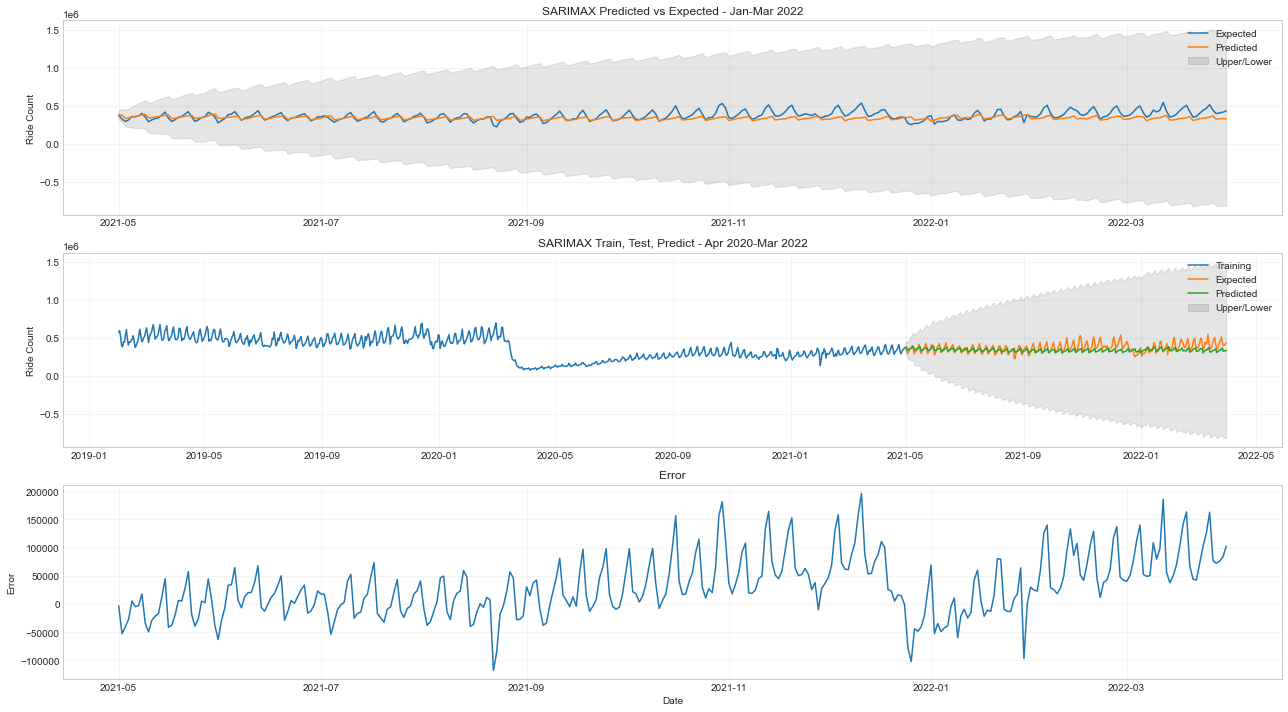

rmse   mape z_score    pvalue observed_mean  \
sarimax control  73182.06  13.99  12.236       0.0     370507.73   
        model_1   60777.4  11.59   9.228       0.0     370507.73   
prophet control  39541.93   8.07   4.826  0.000001     370507.73   
xgboost control  54352.91   11.5   1.051  0.293268     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
prophet control     350029.01     57620.28      51899.0  
xgboost control     367160.06     57620.28      8344.25

In [62]:
X_train_1 = pd.concat([X_train, temp_train], axis=1)
X_test_1 = pd.concat([X_test, temp_test], axis=1)
sarimax_mod_1 = get_sarimax(y_train, y_test, X_train_1, X_test_1)
get_metrics(sarimax_mod_1, metrics, 'sarimax', 'model_1').dropna()

#### SARIMAX Model 2: Weather, Precipitation
***

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                   uber   No. Observations:                  820
Model:             SARIMAX(5, 1, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -9916.092
Date:                                Thu, 11 Aug 2022   AIC                          19884.184
Time:                                        19:24:55   BIC                          20006.595
Sample:                                    02-01-2019   HQIC                         19931.157
                                         - 04-30-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dayofweek   8034.8497    371.057     21.654      0.000    7307.592    8762.108
quarter     2801.9523      0.650   4309.515      0.000    2800.678    2803.227
month       1.159e+05      5.635   2.06e+04      0.000    1.16e+05    1.16e+05
year       -9.621e+04        nan        nan        nan         nan         nan
dayofyear  -4006.6771     84.514    -47.408      0.000   -4172.322   -3841.032
dayofmonth  3970.5976    137.753     28.824      0.000    3700.607    4240.588
weekofyear -1019.8917    508.635     -2.005      0.045   -2016.798     -22.985
phase_0     2364.8141      0.003   9.22e+05      0.000    2364.809    2364.819
phase_1    -1.578e+04      0.000  -3.65e+07      0.000   -1.58e+04   -1.58e+04
phase_2    -1.734e+04        nan        nan        nan         nan         nan
phase_3     3.075e+04        nan        nan        nan         nan         nan
holiday             0     61.117          0      1.000    -119.788     119.788
prec        1.618e+04      2.900   5577.483      0.000    1.62e+04    1.62e+04
ar.L1          0.0002      3.057   6.48e-05      1.000      -5.991       5.992
ar.L2          0.0001      1.926   6.17e-05      1.000      -3.776       3.776
ar.L3         -0.0011      0.281     -0.004      0.997      -0.552       0.550
ar.L4         -0.0001      0.025     -0.005      0.996      -0.049       0.048
ar.L5          0.0002      0.005      0.044      0.965      -0.010       0.011
ma.L1         -0.0001      3.057  -4.04e-05      1.000      -5.992       5.991
ma.L2         -0.0006      1.927     -0.000      1.000      -3.777       3.775
ma.L3          0.0008      0.281      0.003      0.998      -0.550       0.552
ar.S.L7        0.2596      0.925      0.281      0.779      -1.554       2.073
ar.S.L14       0.6890      0.905      0.762      0.446      -1.084       2.462
ma.S.L7       -0.2591      0.925     -0.280      0.779      -2.072       1.554
ma.S.L14      -0.6889      0.904     -0.762      0.446      -2.461       1.083
sigma2      9.615e+08        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   9.33   Jarque-Bera (JB):               112.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -0.71
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.38e+26. Standard errors may be unstable.
"""

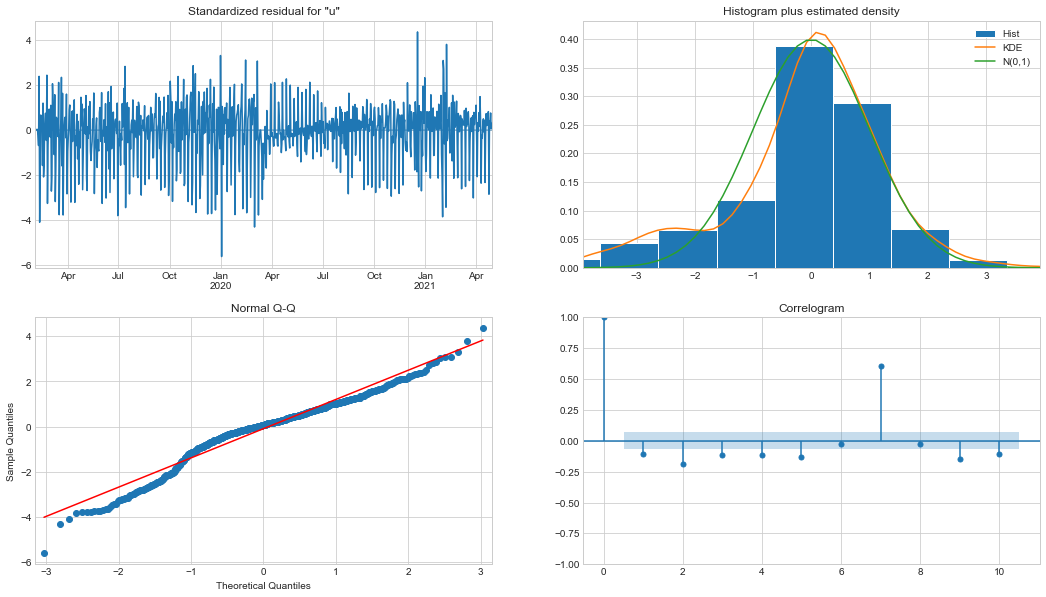

expected      predicted         error          lower  \
2021-05-01  377323.0  377158.229655    164.770345  316382.614721   
2021-05-02  324331.0  384317.526029 -59986.526029  298364.630268   
2021-05-03  295623.0  344621.184741 -48998.184741  239366.357044   

                    upper  
2021-05-01  437933.844589  
2021-05-02  470270.421790  
2021-05-03  449876.012438

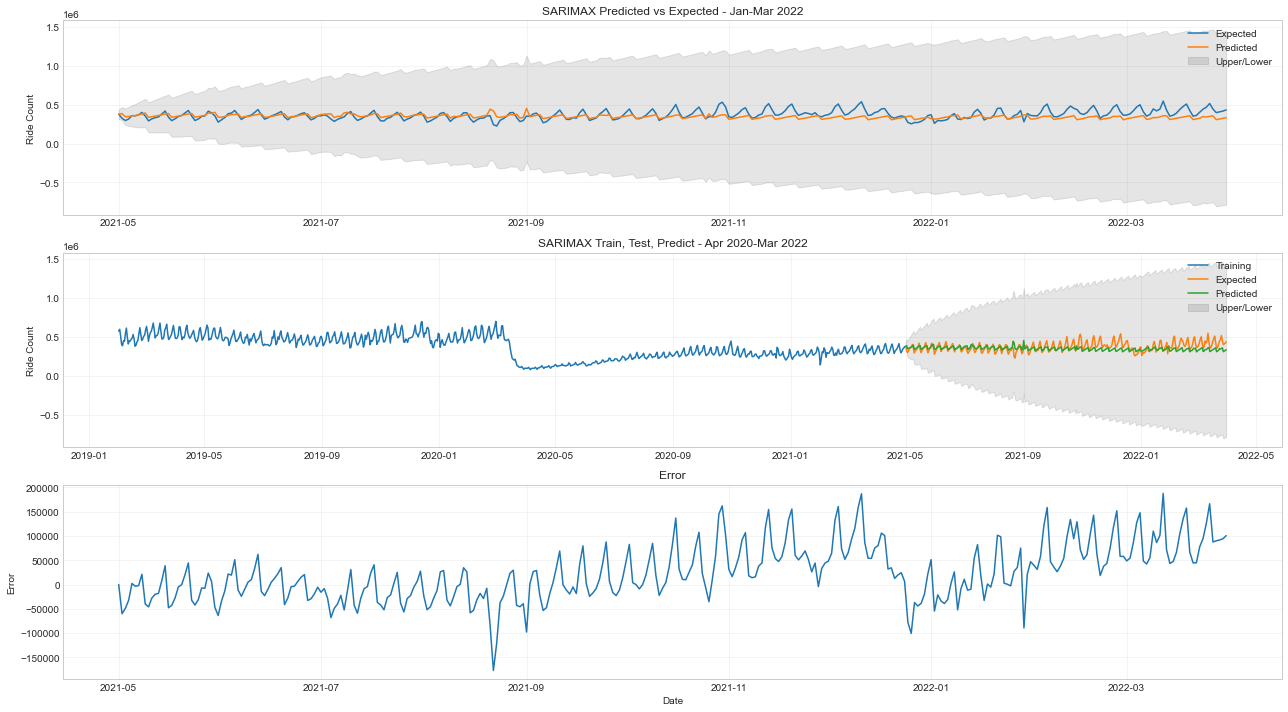

rmse   mape z_score    pvalue observed_mean  \
sarimax control  73182.06  13.99  12.236       0.0     370507.73   
        model_1   60777.4  11.59   9.228       0.0     370507.73   
        model_2  62094.37  12.21    7.03       0.0     370507.73   
prophet control  39541.93   8.07   4.826  0.000001     370507.73   
xgboost control  54352.91   11.5   1.051  0.293268     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
prophet control     350029.01     57620.28      51899.0  
xgboost control     367160.06     57620.28      8344.25

In [63]:
X_train_2 = pd.concat([X_train, prec_train], axis=1)
X_test_2 = pd.concat([X_test, prec_test], axis=1)
sarimax_mod_2 = get_sarimax(y_train, y_test, X_train_2, X_test_2)
get_metrics(sarimax_mod_2, metrics, 'sarimax', 'model_2').dropna()

#### SARIMAX Model 3: Covid-19, Cases

***

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                   uber   No. Observations:                  820
Model:             SARIMAX(5, 1, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -9931.337
Date:                                Thu, 11 Aug 2022   AIC                          19914.674
Time:                                        19:26:47   BIC                          20037.084
Sample:                                    02-01-2019   HQIC                         19961.646
                                         - 04-30-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dayofweek   7889.8281    369.028     21.380      0.000    7166.547    8613.109
quarter    -1660.4678      0.654  -2539.050      0.000   -1661.750   -1659.186
month       7.487e+04      6.587   1.14e+04      0.000    7.49e+04    7.49e+04
year       -9.947e+04      0.166  -5.99e+05      0.000   -9.95e+04   -9.95e+04
dayofyear  -2629.4202     96.870    -27.144      0.000   -2819.282   -2439.558
dayofmonth  2600.1184    161.197     16.130      0.000    2284.177    2916.059
weekofyear -1013.7768    727.374     -1.394      0.163   -2439.403     411.850
phase_0     4862.2314        nan        nan        nan         nan         nan
phase_1    -1.358e+04      0.000   -3.9e+07      0.000   -1.36e+04   -1.36e+04
phase_2    -1.427e+04        nan        nan        nan         nan         nan
phase_3     2.298e+04        nan        nan        nan         nan         nan
holiday             0     15.452          0      1.000     -30.286      30.286
case          19.7902      9.388      2.108      0.035       1.390      38.190
ar.L1          0.0002      1.640      0.000      1.000      -3.214       3.215
ar.L2          0.0002      1.715      0.000      1.000      -3.361       3.362
ar.L3         -0.0015      0.275     -0.005      0.996      -0.541       0.538
ar.L4         -0.0001      0.025     -0.005      0.996      -0.049       0.048
ar.L5          0.0003      0.005      0.052      0.959      -0.010       0.010
ma.L1         -0.0001      1.640  -6.15e-05      1.000      -3.214       3.214
ma.L2         -0.0007      1.715     -0.000      1.000      -3.362       3.361
ma.L3          0.0012      0.275      0.004      0.997      -0.537       0.540
ar.S.L7        0.2503      0.902      0.278      0.781      -1.517       2.017
ar.S.L14       0.6901      0.878      0.786      0.432      -1.030       2.411
ma.S.L7       -0.2498      0.901     -0.277      0.782      -2.016       1.517
ma.S.L14      -0.6900      0.877     -0.786      0.432      -2.409       1.030
sigma2      9.875e+08        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   9.07   Jarque-Bera (JB):                88.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.74e+27. Standard errors may be unstable.
"""

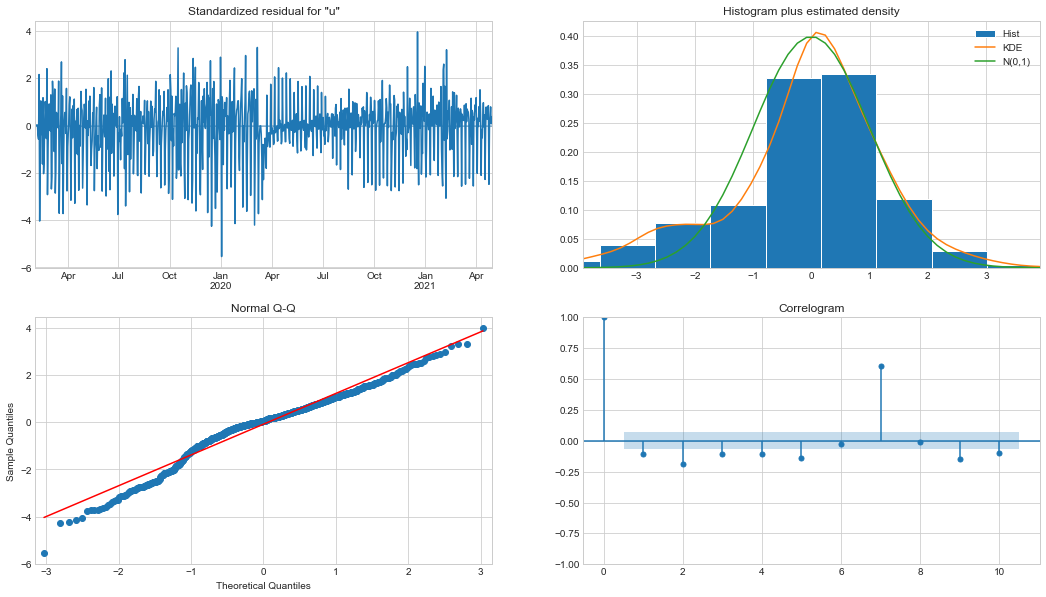

expected      predicted         error          lower  \
2021-05-01  377323.0  376779.004762    543.995238  315188.903818   
2021-05-02  324331.0  383378.362221 -59047.362221  296273.678951   
2021-05-03  295623.0  333943.605934 -38320.605934  227277.824595   

                    upper  
2021-05-01  438369.105706  
2021-05-02  470483.045491  
2021-05-03  440609.387272

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
prophet control     350029.01     57620.28      51899.0  
xgboost control     367160.06     57620.28      8344.25

In [64]:
X_train_3 = pd.concat([X_train, cases_train], axis=1)
X_test_3 = pd.concat([X_test, cases_test], axis=1)
sarimax_mod_3 = get_sarimax(y_train, y_test, X_train_3, X_test_3)
get_metrics(sarimax_mod_3, metrics, 'sarimax', 'model_3').dropna()

#### SARIMAX Model 4: Covid-19, Hospitalizations
***

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                   uber   No. Observations:                  820
Model:             SARIMAX(5, 1, 3)x(2, 0, [1, 2], 7)   Log Likelihood              -10133.426
Date:                                Thu, 11 Aug 2022   AIC                          20318.851
Time:                                        19:28:18   BIC                          20441.261
Sample:                                    02-01-2019   HQIC                         20365.823
                                         - 04-30-2021                                         
Covariance Type:                                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dayofweek     7888.1297      7.080   1114.137      0.000    7874.253    7902.006
quarter       -436.7785      1.080   -404.395      0.000    -438.895    -434.662
month         8.889e+04      6.013   1.48e+04      0.000    8.89e+04    8.89e+04
year         -8.598e+04      0.268  -3.21e+05      0.000    -8.6e+04    -8.6e+04
dayofyear    -3067.9176     98.937    -31.009      0.000   -3261.830   -2874.005
dayofmonth    3091.8736    142.238     21.737      0.000    2813.092    3370.656
weekofyear   -1052.2102      1.501   -701.023      0.000   -1055.152   -1049.268
phase_0       5077.9831      0.001   4.77e+06      0.000    5077.981    5077.985
phase_1      -1.212e+04      0.001   -2.2e+07      0.000   -1.21e+04   -1.21e+04
phase_2      -1.414e+04      0.000  -4.16e+07      0.000   -1.41e+04   -1.41e+04
phase_3       2.118e+04      0.000   8.43e+07      0.000    2.12e+04    2.12e+04
holiday               0     53.554          0      1.000    -104.963     104.963
hospitalized   -78.0879     64.477     -1.211      0.226    -204.460      48.284
ar.L1           -0.1708      0.015    -11.157      0.000      -0.201      -0.141
ar.L2           -0.4000      0.010    -38.442      0.000      -0.420      -0.380
ar.L3           -0.8526      0.015    -56.520      0.000      -0.882      -0.823
ar.L4            0.0005      0.000      3.509      0.000       0.000       0.001
ar.L5           -0.0009   6.03e-05    -14.963      0.000      -0.001      -0.001
ma.L1            0.1707      0.015     11.180      0.000       0.141       0.201
ma.L2            0.4001      0.010     38.501      0.000       0.380       0.420
ma.L3            0.8520      0.015     56.236      0.000       0.822       0.882
ar.S.L7          0.2938      0.026     11.343      0.000       0.243       0.345
ar.S.L14         0.6363      0.024     26.278      0.000       0.589       0.684
ma.S.L7         -0.2919      0.026    -11.275      0.000      -0.343      -0.241
ma.S.L14        -0.6366      0.024    -26.324      0.000      -0.684      -0.589
sigma2        1.023e+09   9.37e-05   1.09e+13      0.000    1.02e+09    1.02e+09
===================================================================================
Ljung-Box (L1) (Q):                  11.25   Jarque-Bera (JB):                91.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.63e+28. Standard errors may be unstable.
"""

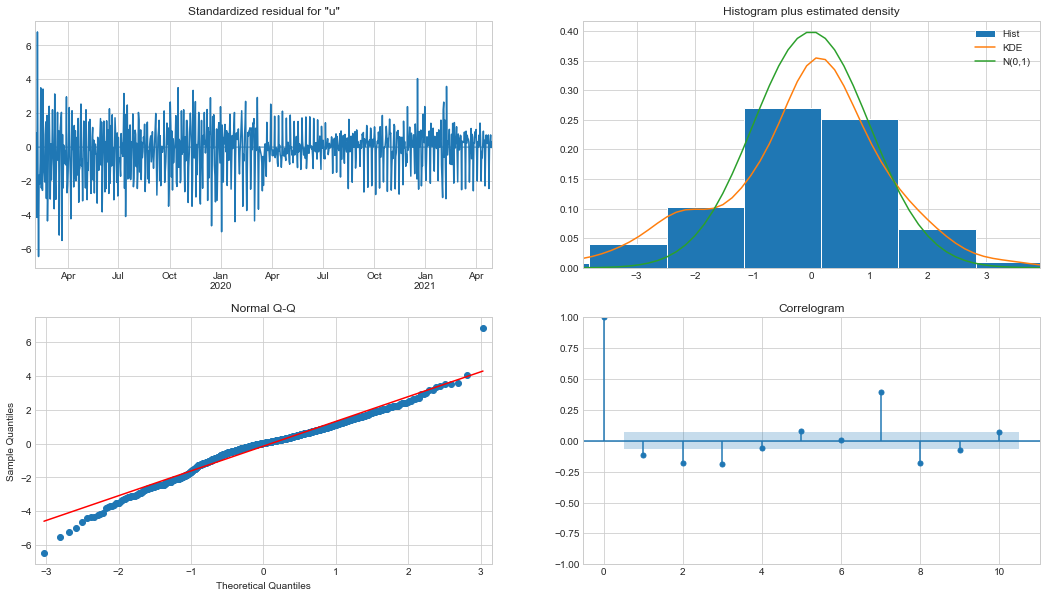

expected      predicted         error          lower  \
2021-05-01  377323.0  375143.738870   2179.261130  312451.434569   
2021-05-02  324331.0  380722.086801 -56391.086801  292067.784593   
2021-05-03  295623.0  334252.574889 -38629.574889  225670.365405   

                    upper  
2021-05-01  437836.043170  
2021-05-02  469376.389010  
2021-05-03  442834.784372

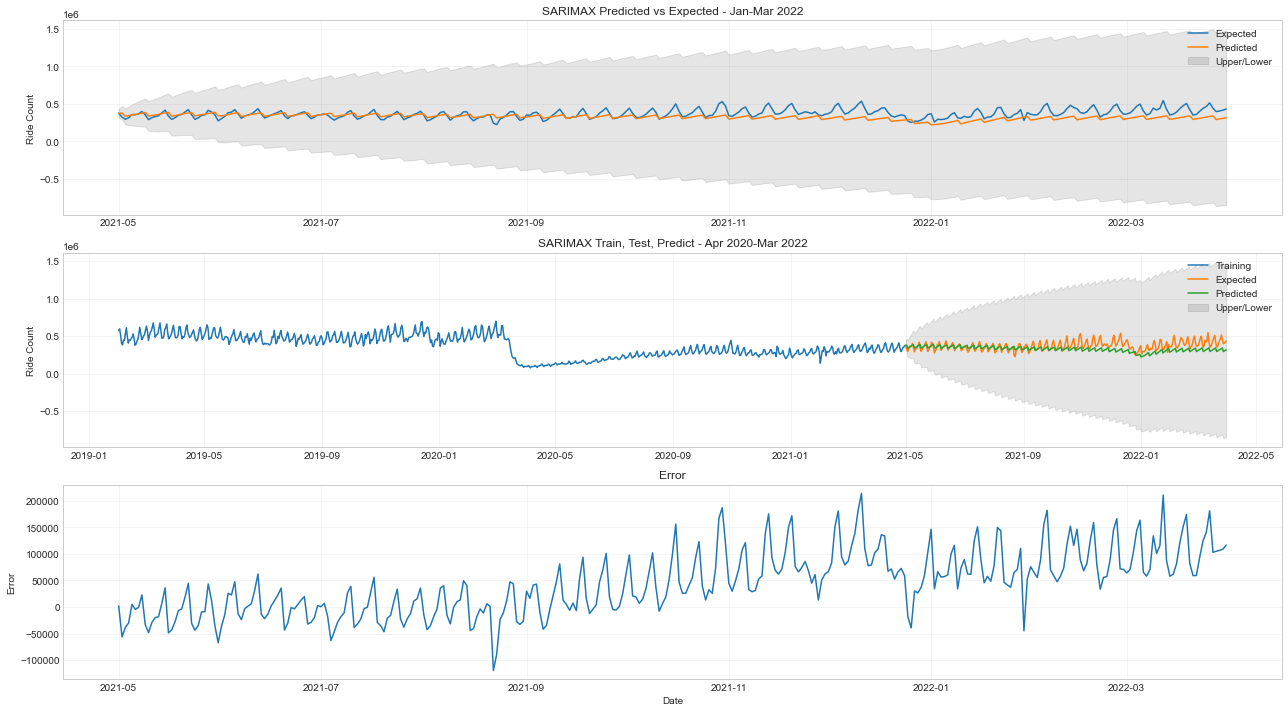

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
prophet control     350029.01     57620.28      51899.0  
xgboost control     367160.06     57620.28      8344.25

In [65]:
X_train_4 = pd.concat([X_train, hosp_train], axis=1)
X_test_4 = pd.concat([X_test, hosp_test], axis=1)
sarimax_mod_4 = get_sarimax(y_train, y_test, X_train_4, X_test_4)
get_metrics(sarimax_mod_4, metrics, 'sarimax', 'model_4').dropna()

#### SARIMAX Model 5: Covid-19, Death
***

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                   uber   No. Observations:                  820
Model:             SARIMAX(5, 1, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -9925.254
Date:                                Thu, 11 Aug 2022   AIC                          19902.508
Time:                                        19:29:43   BIC                          20024.918
Sample:                                    02-01-2019   HQIC                         19949.480
                                         - 04-30-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dayofweek   7888.5033    387.837     20.340      0.000    7128.358    8648.649
quarter     -610.2667      1.118   -545.746      0.000    -612.458    -608.075
month       8.816e+04      6.570   1.34e+04      0.000    8.81e+04    8.82e+04
year       -8.893e+04        nan        nan        nan         nan         nan
dayofyear  -3049.4526    101.201    -30.133      0.000   -3247.803   -2851.103
dayofmonth  3062.6943    158.531     19.319      0.000    2751.980    3373.408
weekofyear -1048.1328    682.733     -1.535      0.125   -2386.266     290.000
phase_0     5459.4689      0.001   1.07e+07      0.000    5459.468    5459.470
phase_1    -1.258e+04      0.000  -2.59e+07      0.000   -1.26e+04   -1.26e+04
phase_2    -1.405e+04      0.000  -4.35e+07      0.000    -1.4e+04    -1.4e+04
phase_3     2.117e+04        nan        nan        nan         nan         nan
holiday             0     39.931          0      1.000     -78.264      78.264
death        -60.8019    217.759     -0.279      0.780    -487.602     365.999
ar.L1          0.0002      1.725      0.000      1.000      -3.381       3.382
ar.L2       8.161e-05      1.805   4.52e-05      1.000      -3.538       3.538
ar.L3         -0.0013      0.284     -0.005      0.996      -0.557       0.555
ar.L4         -0.0001      0.016     -0.009      0.993      -0.032       0.032
ar.L5          0.0003      0.005      0.058      0.954      -0.010       0.010
ma.L1      -9.625e-05      1.725  -5.58e-05      1.000      -3.382       3.381
ma.L2         -0.0006      1.805     -0.000      1.000      -3.539       3.538
ma.L3          0.0009      0.284      0.003      0.997      -0.556       0.558
ar.S.L7        0.2607      0.988      0.264      0.792      -1.676       2.197
ar.S.L14       0.6772      0.960      0.705      0.481      -1.205       2.559
ma.S.L7       -0.2601      0.988     -0.263      0.792      -2.196       1.675
ma.S.L14      -0.6770      0.960     -0.706      0.480      -2.558       1.204
sigma2      1.015e+09        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   9.72   Jarque-Bera (JB):                88.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.09e+27. Standard errors may be unstable.
"""

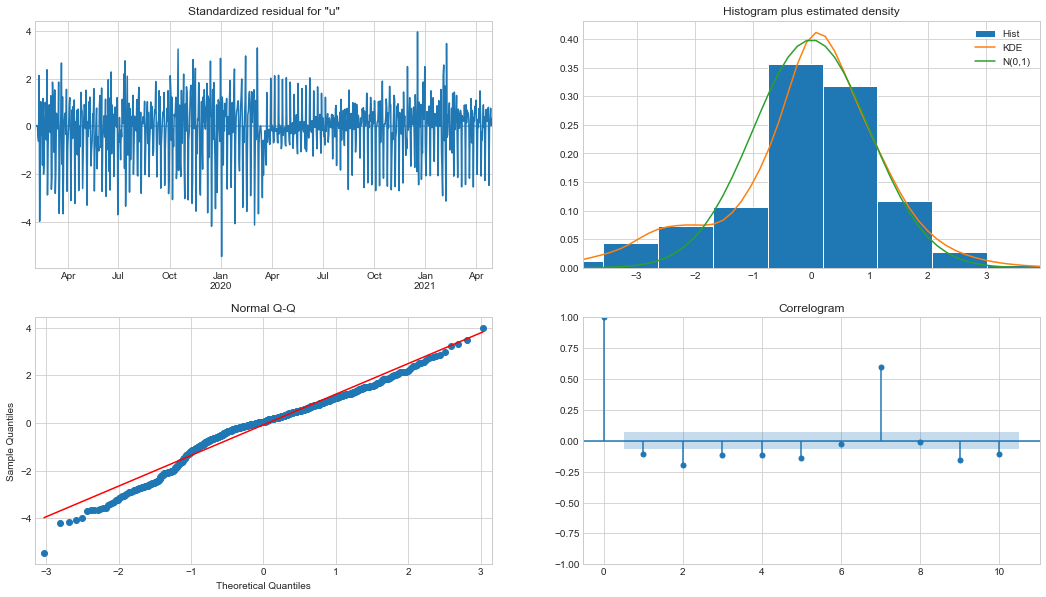

expected      predicted         error          lower  \
2021-05-01  377323.0  376946.302183    376.697817  314505.802088   
2021-05-02  324331.0  383996.017257 -59665.017257  295688.349262   
2021-05-03  295623.0  335941.563887 -40318.563887  227804.555002   

                    upper  
2021-05-01  439386.802277  
2021-05-02  472303.685251  
2021-05-03  444078.572771

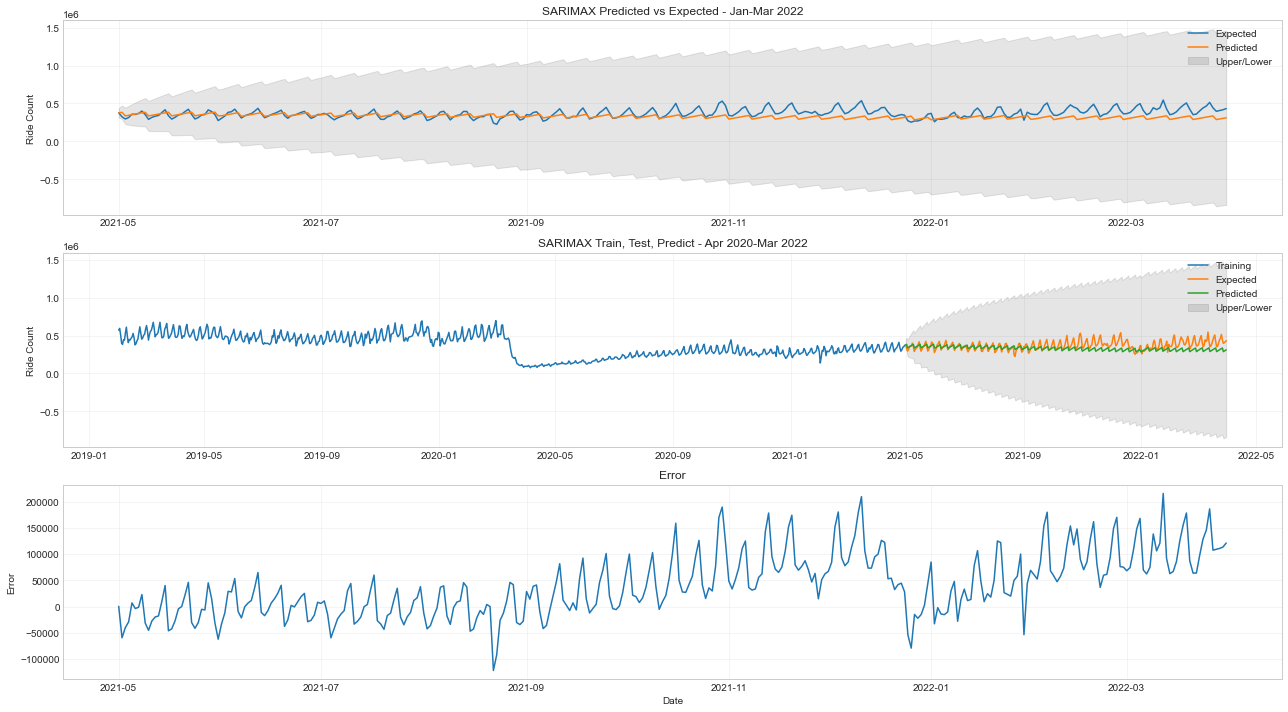

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
prophet control     350029.01     57620.28      51899.0  
xgboost control     367160.06     57620.28      8344.25

In [66]:
X_train_5 = pd.concat([X_train, death_train], axis=1)
X_test_5 = pd.concat([X_test, death_test], axis=1)
sarimax_mod_5 = get_sarimax(y_train, y_test, X_train_5, X_test_5)
get_metrics(sarimax_mod_5, metrics, 'sarimax', 'model_5').dropna()

#### SARIMAX Model 6: Covid-19, Vaccinations
***

In [67]:
X_train_6 = pd.concat([X_train, vax_train], axis=1)
X_test_6 = pd.concat([X_test, vax_test], axis=1)
sarimax_mod_6 = get_sarimax(y_train, y_test, X_train_6, X_test_6)
get_metrics(sarimax_mod_6, metrics, 'sarimax', 'model_6').dropna()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                   uber   No. Observations:                  820
Model:             SARIMAX(5, 1, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -9924.461
Date:                                Thu, 11 Aug 2022   AIC                          19900.921
Time:                                        19:31:10   BIC                          20023.332
Sample:                                    02-01-2019   HQIC                         19947.894
                                         - 04-30-2021                                         
Covariance Type:                                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
dayofweek    7892.6999    369.178     21.379      0.000    7169.125    8616.275
quarter     -1026.8113      0.896  -1146.554      0.000   -1028.567   -1025.056
month        9.152e+04      6.557    1.4e+04      0.000    9.15e+04    9.15e+04
year        -8.234e+04        nan        nan        nan         nan         nan
dayofyear   -3138.4506    102.446    -30.635      0.000   -3339.241   -2937.660
dayofmonth   3172.2564    157.810     20.102      0.000    2862.955    3481.558
weekofyear  -1046.4351    685.555     -1.526      0.127   -2390.098     297.228
phase_0      3.049e+04        nan        nan        nan         nan         nan
phase_1      1.242e+04      0.000   3.05e+07      0.000    1.24e+04    1.24e+04
phase_2      1.093e+04        nan        nan        nan         nan         nan
phase_3     -5.384e+04        nan        nan        nan         nan         nan
holiday              0     25.019          0      1.000     -49.036      49.036
vaccination     0.9619      0.580      1.659      0.097      -0.175       2.098
ar.L1           0.0002      1.727   9.57e-05      1.000      -3.384       3.385
ar.L2        -1.79e-05      1.824  -9.82e-06      1.000      -3.575       3.575
ar.L3          -0.0012      0.285     -0.004      0.997      -0.559       0.557
ar.L4          -0.0002      0.013     -0.013      0.990      -0.025       0.024
ar.L5           0.0003      0.005      0.067      0.946      -0.009       0.010
ma.L1       -8.143e-05      1.727  -4.72e-05      1.000      -3.385       3.385
ma.L2          -0.0005      1.824     -0.000      1.000      -3.575       3.574
ma.L3           0.0008      0.284      0.003      0.998      -0.557       0.558
ar.S.L7         0.2623      1.023      0.256      0.798      -1.743       2.268
ar.S.L14        0.6703      0.992      0.676      0.499      -1.273       2.614
ma.S.L7        -0.2616      1.023     -0.256      0.798      -2.266       1.743
ma.S.L14       -0.6701      0.991     -0.676      0.499      -2.612       1.272
sigma2       1.013e+09        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   9.23   Jarque-Bera (JB):                88.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.8e+26. Standard errors may be unstable.
"""

expected      predicted         error          lower  \
2021-05-01  377323.0  341374.937295  35948.062705  278997.718713   
2021-05-02  324331.0  328968.603669  -4637.603669  240750.197798   
2021-05-03  295623.0  287187.562675   8435.437325  179161.256080   

                    upper  
2021-05-01  403752.155878  
2021-05-02  417187.009541  
2021-05-03  395213.869270

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
        model_6     267818.63     57620.28     33313.48  
prophet control     350029.01     57620.28      51899.0  
xgboost control     367160.06     57620.28      8344.25

### Prophet
***

In [68]:
def get_prophet(train, regressors, test):
    # Create model
    m = Prophet(daily_seasonality=7)
    # Add regressors
    for col in regressors.columns:
        m.add_regressor(col)
    # Train model
    m.fit(train)
    # Make future dataframe    
    future = m.make_future_dataframe(periods=len(test), freq='D')
    future = pd.concat([future, regressors], axis=1)
    # Forecast
    forecast = m.predict(future)
    forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    # Make results dataframe
    results = forecast.set_index('ds')
    results.index.name = None
    train_test = pd.concat([train[['y']], test[['y']]]).reset_index(drop=True)
    results['expected'] = train_test.values
    results['error'] = (results.expected - results.yhat)/2
    results.columns.values[:-2] = ['predicted', 'lower', 'upper']
    results = results[['expected', 'predicted', 'error', 'lower', 'upper']]
    results = results[test_start:]
    # Display results
    display(results.head(3))
    # Plot results
    plot_results(results, 'Prophet', train.set_index('ds')['y'])
    plt.show()
    # Return results
    return results

#### Prophet Model 1: Weather, Temperature
***

Initial log joint probability = -21.9873
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1885.41    0.00632231       224.494           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1889.39    0.00160814       104.636           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1890.63    0.00181676       83.6421       0.407           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     379        1890.7   0.000236554       76.2767   2.467e-06       0.001      496  LS failed, Hessian reset 
     399       1890.71   2.48698e-05       70.1954      0.9391      0.9391      519   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     419       1890.72   2.74429e-06    

expected      predicted         error          lower  \
2021-05-01  377323.0  421560.022021 -22118.511011  368233.797223   
2021-05-02  324331.0  353281.867255 -14475.433628  301638.822726   
2021-05-03  295623.0  310228.082131  -7302.541065  257212.835654   

                    upper  
2021-05-01  476297.025071  
2021-05-02  407175.930901  
2021-05-03  363333.753321

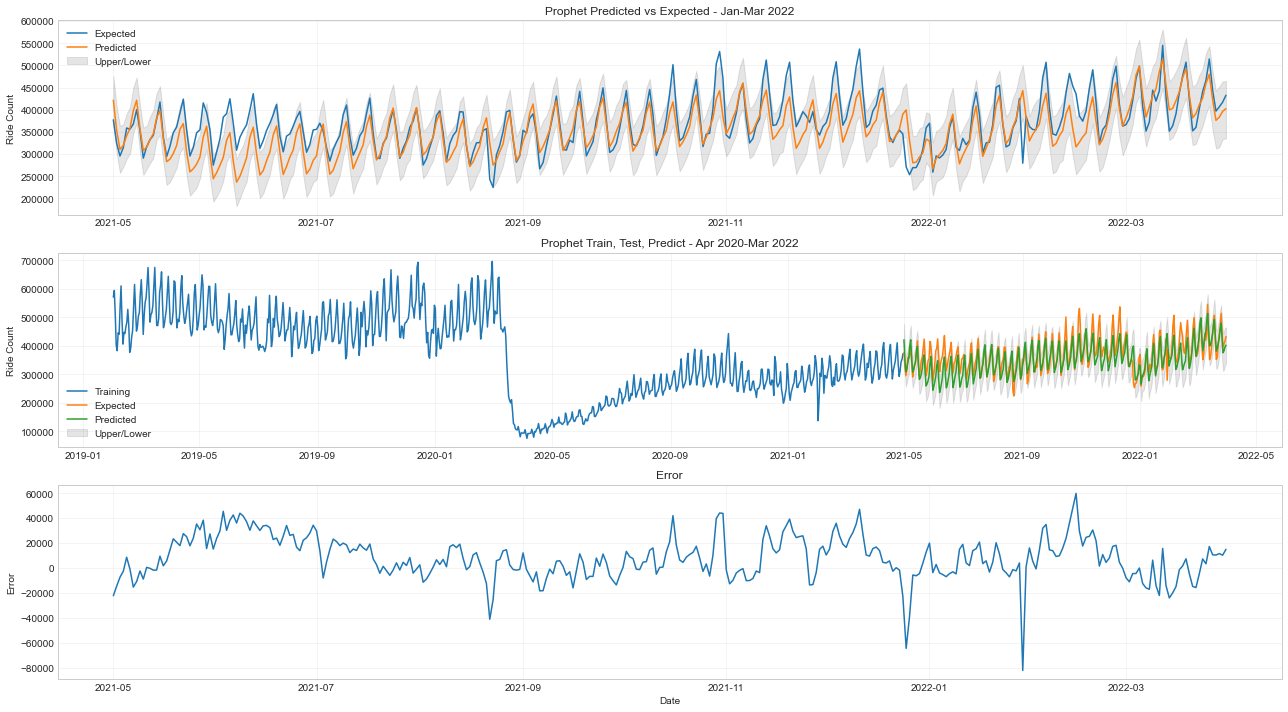

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
        model_1   38032.45   7.75    3.98  0.000069     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
        model_6     267818.63     57620.28     33313.48  
prophet control     350029.01     57620.28      51899.0  
        model_1     353562.34     57620.28     52301.35  
xgboost control     367160.06     57620.28      8344.25

In [69]:
prophet_1_train = pd.concat([prophet_train, temp_train.reset_index(drop=True)], axis=1)
prophet_1_test = pd.concat([regressors, temp], axis=1).reset_index(drop=True)
prophet_1_results = get_prophet(prophet_1_train, prophet_1_test, prophet_test)
get_metrics(prophet_1_results, metrics, 'prophet', 'model_1').dropna()

#### Prophet Model 2: Weather, Precipitation

***

In [70]:
prophet_2_train = pd.concat([prophet_train, prec_train.reset_index(drop=True)], axis=1)
prophet_2_test = pd.concat([regressors, prec], axis=1).reset_index(drop=True)
prophet_2_results = get_prophet(prophet_2_train, prophet_2_test, prophet_test)
get_metrics(prophet_2_results, metrics, 'prophet', 'model_2').dropna()

Initial log joint probability = -21.9873
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1894.56   0.000278861       120.699      0.3484      0.3484      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1899.08   7.77472e-05        90.383      0.5014      0.5014      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       1899.21   0.000261467       152.335   2.922e-06       0.001      286  LS failed, Hessian reset 
     299       1899.45     0.0102227       138.992           1           1      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       1899.69   0.000224131       241.801   1.357e-06       0.001      437  LS failed, Hessian reset 
     399       1899.96   0.000410671       64.3214       5.725      0.5725      550   
    Iter      log pro

expected      predicted         error          lower  \
2021-05-01  377323.0  420433.226328 -21555.113164  366482.697361   
2021-05-02  324331.0  359444.219505 -17556.609753  306539.227341   
2021-05-03  295623.0  323572.643038 -13974.821519  275373.291041   

                    upper  
2021-05-01  471461.727753  
2021-05-02  414649.466576  
2021-05-03  376382.950779

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
        model_1   38032.45   7.75    3.98  0.000069     370507.73   
        model_2   39468.39   7.91   3.291  0.000999     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
        model_6     267818.63     57620.28     33313.48  
prophet control     350029.01     57620.28      51899.0  
        model_1     353562.34     57620.28     52301.35  
        model_2     356359.16     57620.28     53418.19  
xgboost control     367160.06     57620.28      8344.25

#### Prophet Model 3: Covid-19, Cases

***

Initial log joint probability = -21.9873
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1927.11   0.000637592       504.588      0.5613      0.5613      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1934.11    0.00100907       202.456       1.363      0.1363      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       1935.73   0.000124419       125.673   4.369e-07       0.001      340  LS failed, Hessian reset 
     299       1936.59    0.00117639       109.343           1           1      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1939.89   0.000106091       99.8665      0.4441      0.4441      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     446        1940.1   0.000134683    

expected      predicted         error          lower  \
2021-05-01  377323.0  420083.803936 -21380.401968  370936.578825   
2021-05-02  324331.0  359191.069269 -17430.034634  311144.342595   
2021-05-03  295623.0  311775.660744  -8076.330372  263334.064805   

                    upper  
2021-05-01  467697.480256  
2021-05-02  403394.069071  
2021-05-03  360618.163355

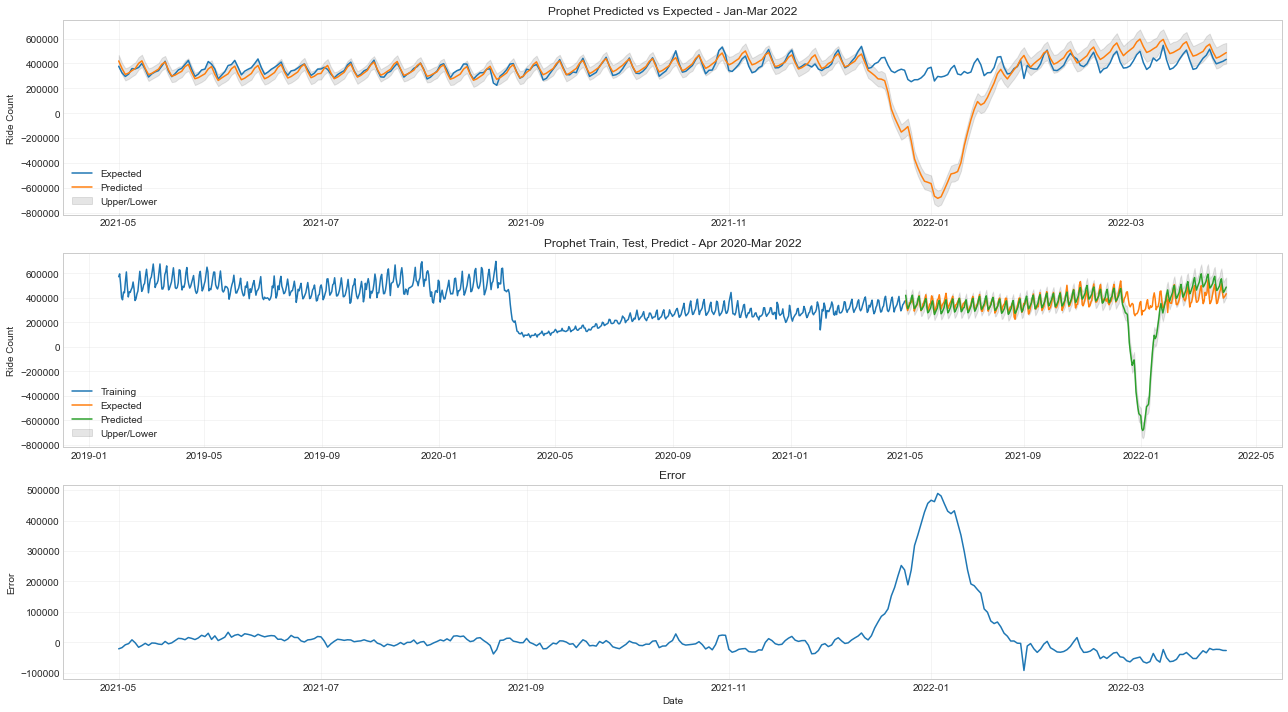

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
        model_1   38032.45   7.75    3.98  0.000069     370507.73   
        model_2   39468.39   7.91   3.291  0.000999     370507.73   
        model_3  205198.04  26.45   3.808   0.00014     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
        model_6     267818.63     57620.28     33313.48  
prophet control     350029.01     57620.28      51899.0  
        model_1     353562.34     57620.28     52301.35  
        model_2     356359.16     57620.28     53418.19  
        model_3     323071.44     57620.28    220238.15  
xgboost control     367160.06     57620.28      8344.25

In [71]:
prophet_3_train = pd.concat([prophet_train, cases_train.reset_index(drop=True)], axis=1)
prophet_3_test = pd.concat([regressors, cases], axis=1).reset_index(drop=True)
prophet_3_results = get_prophet(prophet_3_train, prophet_3_test, prophet_test)
get_metrics(prophet_3_results, metrics, 'prophet', 'model_3').dropna()

#### Prophet Model 4: Covid-19, Hospitalizations

***

In [72]:
prophet_4_train = pd.concat([prophet_train, hosp_train.reset_index(drop=True)], axis=1)
prophet_4_test = pd.concat([regressors, hosp], axis=1).reset_index(drop=True)
prophet_4_results = get_prophet(prophet_4_train, prophet_4_test, prophet_test)
get_metrics(prophet_4_results, metrics, 'prophet', 'model_4').dropna()

Initial log joint probability = -21.9873
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1931.44     0.0060408       192.071           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1937.38    0.00555361       256.999       2.999      0.2999      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1939.67    0.00313725       235.207           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1943.1   0.000661051       80.6597           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     421        1943.2   0.000164058       157.617   1.793e-06       0.001      525  LS failed, Hessian reset 
     499       1943.35   2.29339e-06    

expected      predicted         error          lower  \
2021-05-01  377323.0  402219.814726 -12448.407363  353753.371289   
2021-05-02  324331.0  340898.074263  -8283.537131  295384.197038   
2021-05-03  295623.0  292000.379705   1811.310148  243214.162816   

                    upper  
2021-05-01  449324.982602  
2021-05-02  390958.805068  
2021-05-03  341577.035516

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
        model_1   38032.45   7.75    3.98  0.000069     370507.73   
        model_2   39468.39   7.91   3.291  0.000999     370507.73   
        model_3  205198.04  26.45   3.808   0.00014     370507.73   
        model_4   47045.16  10.34   6.905       0.0     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
        model_6     267818.63     57620.28     33313.48  
prophet control     350029.01     57620.28      51899.0  
        model_1     353562.34     57620.28     52301.35  
        model_2     356359.16     57620.28     53418.19  
        model_3     323071.44     57620.28    220238.15  
        model_4     338952.73     57620.28     60453.77  
xgboost control     367160.06     57620.28      8344.25

#### Prophet Model 5: Covid-19, Deaths

***

Initial log joint probability = -21.9873
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1928.1    0.00424539       260.788           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1932.18    0.00169136       80.8518      0.8496      0.8496      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1932.95   0.000135226       74.5244           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1933.99   0.000569026       94.5369           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1934.45   0.000432229       87.2477      0.4136           1      584   
    Iter      log prob        ||dx||      ||grad||       alpha  

expected      predicted         error          lower  \
2021-05-01  377323.0  400676.123592 -11676.561796  350420.572945   
2021-05-02  324331.0  337547.638696  -6608.319348  285914.854344   
2021-05-03  295623.0  287265.046681   4178.976660  239816.402784   

                    upper  
2021-05-01  447287.034644  
2021-05-02  384887.814946  
2021-05-03  337361.173176

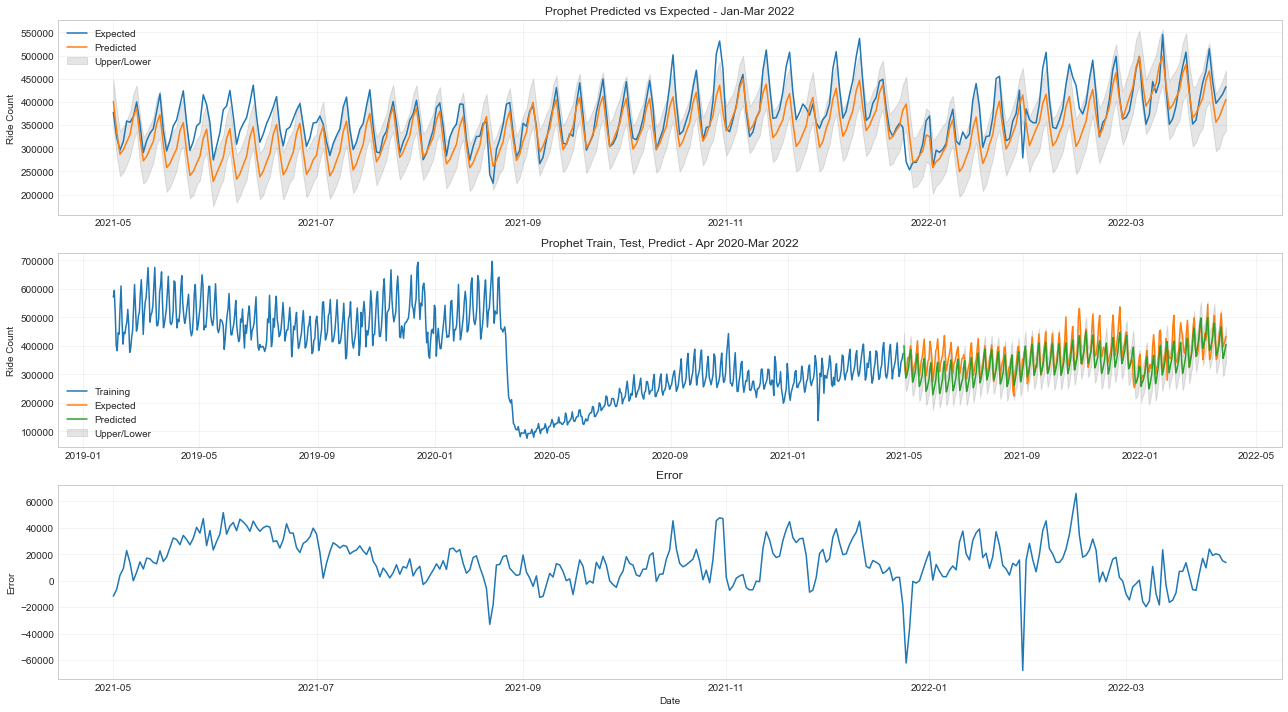

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
        model_1   38032.45   7.75    3.98  0.000069     370507.73   
        model_2   39468.39   7.91   3.291  0.000999     370507.73   
        model_3  205198.04  26.45   3.808   0.00014     370507.73   
        model_4   47045.16  10.34   6.905       0.0     370507.73   
        model_5   44772.84   9.66   6.824       0.0     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
        model_6     267818.63     57620.28     33313.48  
prophet control     350029.01     57620.28      51899.0  
        model_1     353562.34     57620.28     52301.35  
        model_2     356359.16     57620.28     53418.19  
        model_3     323071.44     57620.28    220238.15  
        model_4     338952.73     57620.28     60453.77  
        model_5     340980.83     57620.28     54164.35  
xgboost control     367160.06     57620.28      8344.25

In [73]:
prophet_5_train = pd.concat([prophet_train, death_train.reset_index(drop=True)], axis=1)
prophet_5_test = pd.concat([regressors, death], axis=1).reset_index(drop=True)
prophet_5_results = get_prophet(prophet_5_train, prophet_5_test, prophet_test)
get_metrics(prophet_5_results, metrics, 'prophet', 'model_5').dropna()

#### Prophet Model 6: Covid-19, Vaccinations
***

Initial log joint probability = -21.9873
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1882.16     0.0199202       915.567           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1886.67    0.00120698       111.732      0.1073       0.575      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       1887.23   0.000133367       101.147   9.883e-07       0.001      326  LS failed, Hessian reset 
     293       1887.44    0.00114146       366.656    1.12e-05       0.001      429  LS failed, Hessian reset 
     299       1887.49   0.000386467       60.9163           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334       1887.53   0.000120522       50.4482   1.521e-06       0.001      518  LS failed, Hessian rese

expected      predicted         error          lower  \
2021-05-01  377323.0  412730.706601 -17703.853300  360542.047356   
2021-05-02  324331.0  348671.288006 -12170.144003  296715.234038   
2021-05-03  295623.0  301368.161326  -2872.580663  251055.011976   

                    upper  
2021-05-01  464690.756135  
2021-05-02  398427.557351  
2021-05-03  354229.295816

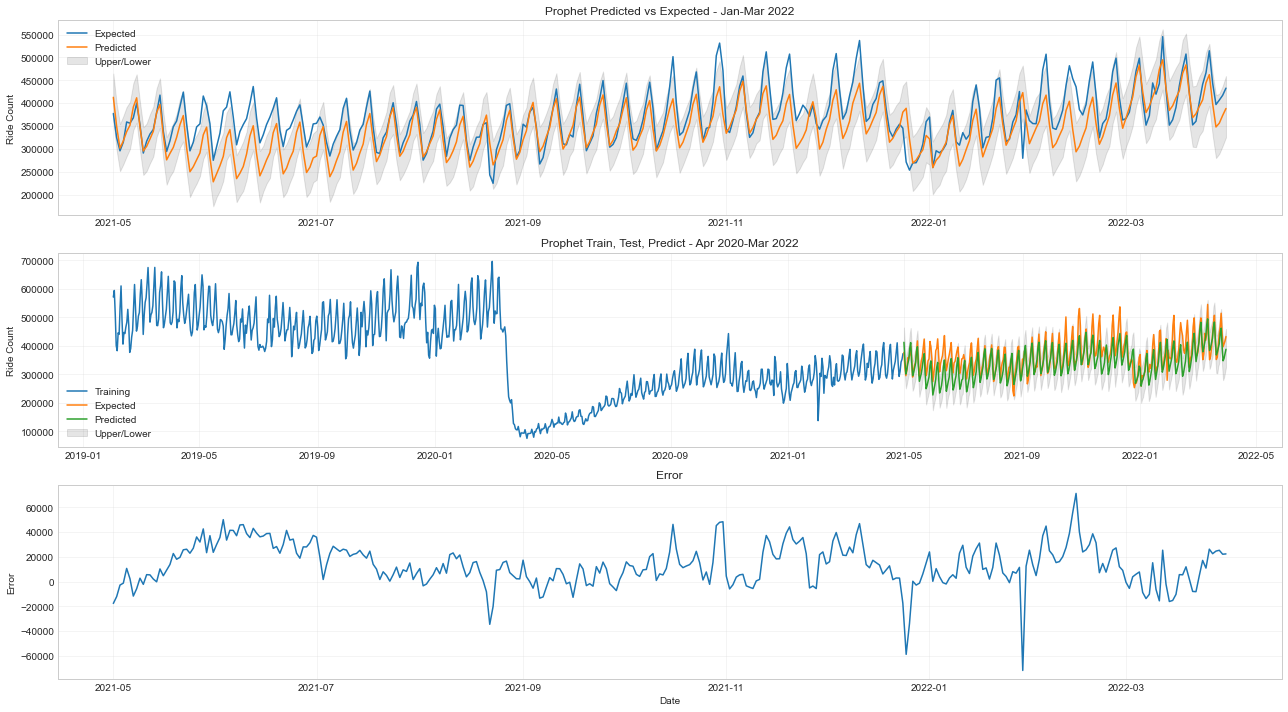

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
        model_1   38032.45   7.75    3.98  0.000069     370507.73   
        model_2   39468.39   7.91   3.291  0.000999     370507.73   
        model_3  205198.04  26.45   3.808   0.00014     370507.73   
        model_4   47045.16  10.34   6.905       0.0     370507.73   
        model_5   44772.84   9.66   6.824       0.0     370507.73   
        model_6   43337.47   9.06   6.487       0.0     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
        model_6     267818.63     57620.28     33313.48  
prophet control     350029.01     57620.28      51899.0  
        model_1     353562.34     57620.28     52301.35  
        model_2     356359.16     57620.28     53418.19  
        model_3     323071.44     57620.28    220238.15  
        model_4     338952.73     57620.28     60453.77  
        model_5     340980.83     57620.28     54164.35  
        model_6     343042.14     57620.28     51647.76  
xgboost control     367160.06     57620.28      8344.25

In [74]:
prophet_6_train = pd.concat([prophet_train, vax_train.reset_index(drop=True)], axis=1)
prophet_6_test = pd.concat([regressors, vax], axis=1).reset_index(drop=True)
prophet_6_results = get_prophet(prophet_6_train, prophet_6_test, prophet_test)
get_metrics(prophet_6_results, metrics, 'prophet', 'model_6').dropna()

### XGBoost
***

In [75]:
temp_scaler = MinMaxScaler()
prec_scaler = MinMaxScaler()
cases_scaler = MinMaxScaler()
hosp_scaler = MinMaxScaler()
death_scaler = MinMaxScaler()
vax_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [76]:
temp_train_scaled, temp_test_scaled = split_train_test(
    pd.DataFrame(temp_scaler.fit_transform(pd.DataFrame(temp)), index=temp.index), train_stop, test_start)

prec_train_scaled, prec_test_scaled = split_train_test(
    pd.DataFrame(prec_scaler.fit_transform(pd.DataFrame(prec)), index=prec.index), train_stop, test_start)

cases_train_scaled, cases_test_scaled = split_train_test(
    pd.DataFrame(cases_scaler.fit_transform(pd.DataFrame(cases)), index=cases.index,), train_stop, test_start)

hosp_train_scaled, hosp_test_scaled = split_train_test(
    pd.DataFrame(hosp_scaler.fit_transform(pd.DataFrame(hosp)), index=hosp.index), train_stop, test_start)

death_train_scaled, death_test_scaled = split_train_test(
    pd.DataFrame(death_scaler.fit_transform(pd.DataFrame(death)), index=death.index,), train_stop, test_start)

vax_train_scaled, vax_test_scaled = split_train_test(
    pd.DataFrame(vax_scaler.fit_transform(pd.DataFrame(vax)), index=vax.index), train_stop, test_start)

y_scaler.fit(uber)

MinMaxScaler()

In [77]:
def get_xgboost(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled):
    # Create model
    reg = xgb.XGBRegressor(n_estimators=1000)
    # Train Model
    reg.fit(X_train_scaled, y_train_scaled, 
            eval_set=[(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)], 
            early_stopping_rounds=50, verbose=False)
    # Plot feature importance
    _ = plot_importance(reg, height=0.9)
    plt.show()
    # Forecast
    preds = reg.predict(X_test_scaled)
    # Make results dataframe
    inverse_preds = y_scaler.inverse_transform(pd.DataFrame(preds))
    results = pd.DataFrame(y_test.values, index=y_test.index, columns=['expected'])
    results['predicted'] = pd.DataFrame(inverse_preds)[0].values
    results['error'] = xgb_results.expected - xgb_results.predicted
    # Display results
    display(results.head(3))
    # Plot results
    plot_results(results, 'XGBoost', y_train)
    plt.show()
    return results

#### XGBoost Model 1: Weather, Temp
***

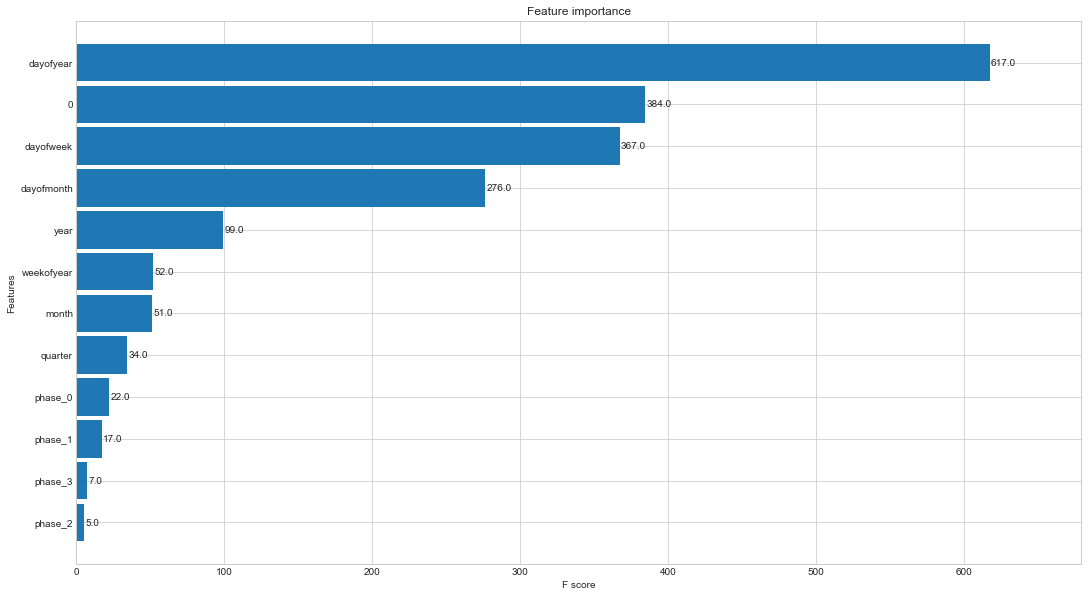

expected     predicted        error
2021-05-01  377323.0  378159.09375  -5194.78125
2021-05-02  324331.0  327635.15625 -52306.31250
2021-05-03  295623.0  323606.96875 -86096.84375

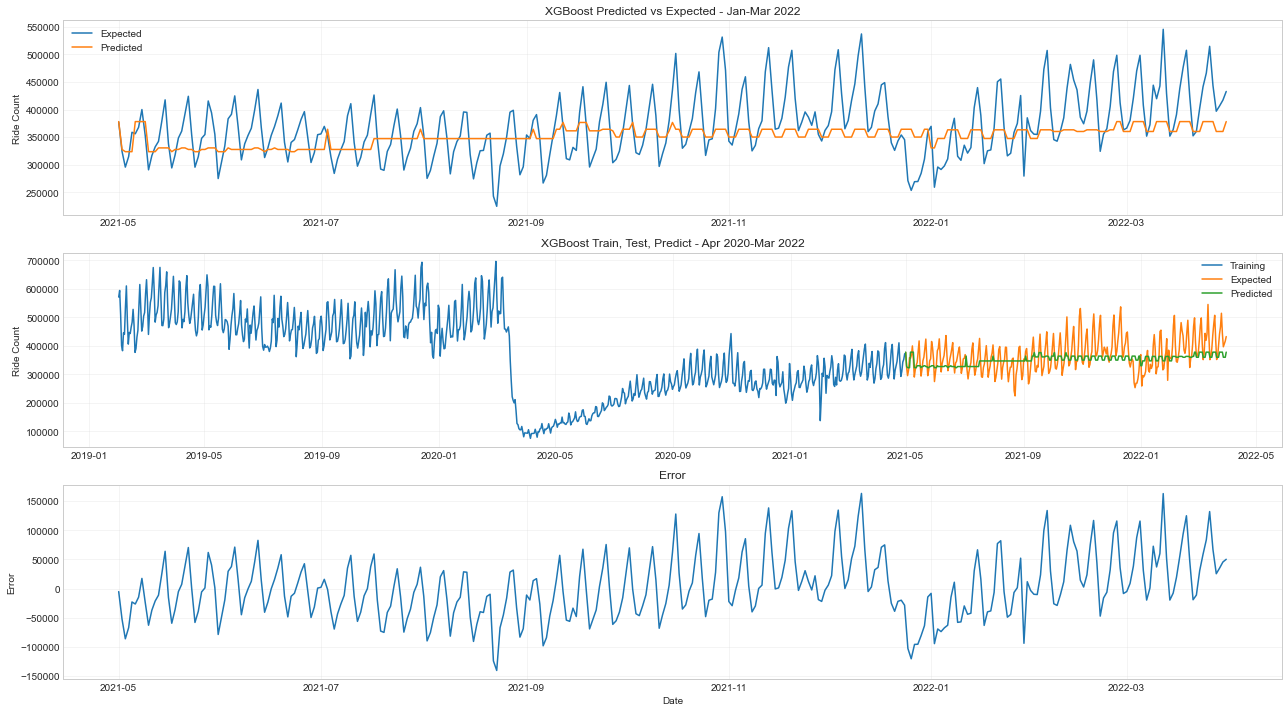

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
        model_1   38032.45   7.75    3.98  0.000069     370507.73   
        model_2   39468.39   7.91   3.291  0.000999     370507.73   
        model_3  205198.04  26.45   3.808   0.00014     370507.73   
        model_4   47045.16  10.34   6.905       0.0     370507.73   
        model_5   44772.84   9.66   6.824       0.0     370507.73   
        model_6   43337.47   9.06   6.487       0.0     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   
        model_1    55134.9  11.04   5.722       0.0     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
        model_6     267818.63     57620.28     33313.48  
prophet control     350029.01     57620.28      51899.0  
        model_1     353562.34     57620.28     52301.35  
        model_2     356359.16     57620.28     53418.19  
        model_3     323071.44     57620.28    220238.15  
        model_4     338952.73     57620.28     60453.77  
        model_5     340980.83     57620.28     54164.35  
        model_6     343042.14     57620.28     51647.76  
xgboost control     367160.06     57620.28      8344.25  
        model_1     351819.16     57620.28      15592.3

In [78]:
xgb_X_train_1 = pd.concat([X_train_scaled, temp_train_scaled], axis=1)
xgb_X_test_1 = pd.concat([X_test_scaled, temp_test_scaled], axis=1)
xgb_1_results = get_xgboost(xgb_X_train_1, xgb_X_test_1, y_train_scaled, y_test_scaled)
get_metrics(xgb_1_results, metrics, 'xgboost', 'model_1').dropna()

#### XGBoost Model 2: Weather, Precipitation
***

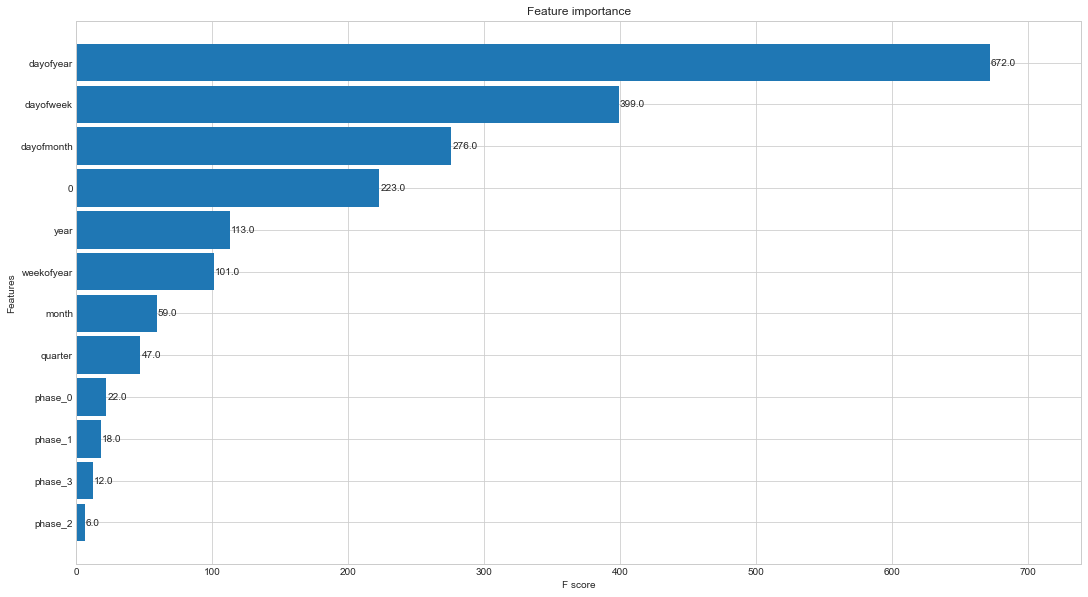

expected     predicted        error
2021-05-01  377323.0  381282.06250  -5194.78125
2021-05-02  324331.0  369900.03125 -52306.31250
2021-05-03  295623.0  379737.65625 -86096.84375

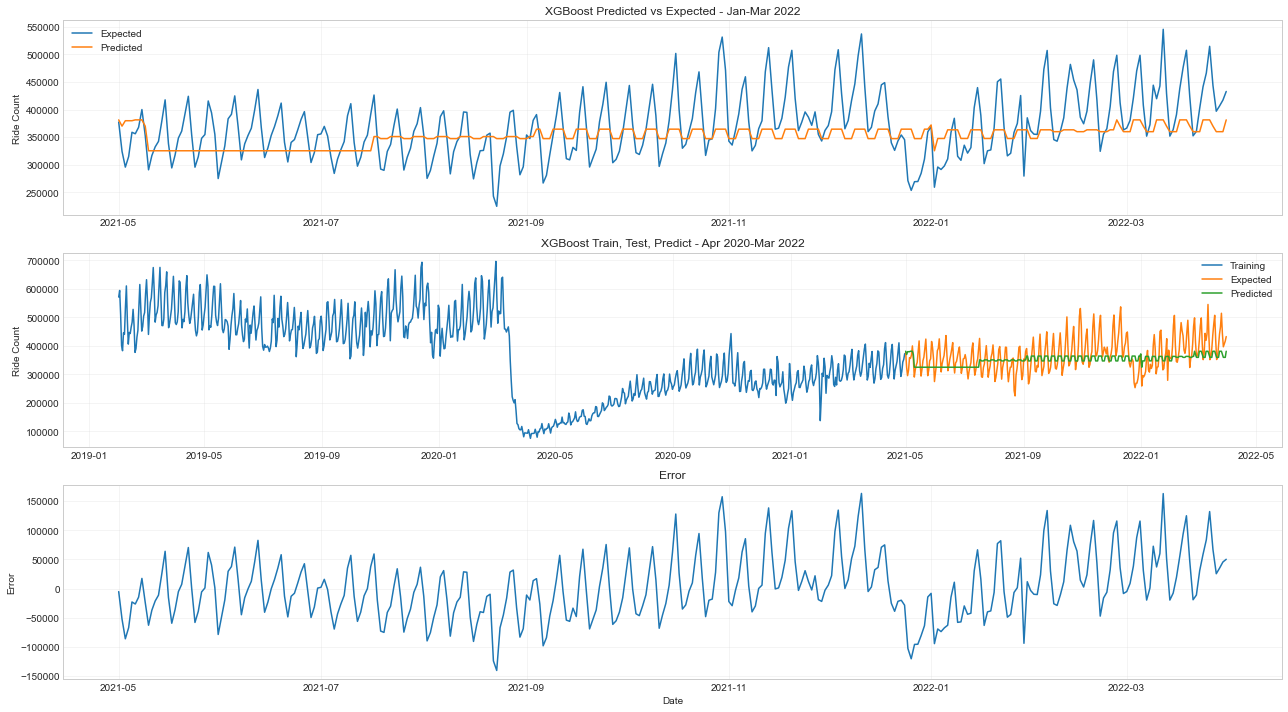

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
        model_1   38032.45   7.75    3.98  0.000069     370507.73   
        model_2   39468.39   7.91   3.291  0.000999     370507.73   
        model_3  205198.04  26.45   3.808   0.00014     370507.73   
        model_4   47045.16  10.34   6.905       0.0     370507.73   
        model_5   44772.84   9.66   6.824       0.0     370507.73   
        model_6   43337.47   9.06   6.487       0.0     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   
        model_1    55134.9  11.04   5.722       0.0     370507.73   
        model_2   55457.54  11.16   5.788       0.0     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
        model_6     267818.63     57620.28     33313.48  
prophet control     350029.01     57620.28      51899.0  
        model_1     353562.34     57620.28     52301.35  
        model_2     356359.16     57620.28     53418.19  
        model_3     323071.44     57620.28    220238.15  
        model_4     338952.73     57620.28     60453.77  
        model_5     340980.83     57620.28     54164.35  
        model_6     343042.14     57620.28     51647.76  
xgboost control     367160.06     57620.28      8344.25  
        model_1     351819.16     57620.28      15592.3  
        model_2     351555.12     57620.28     16150.92

In [79]:
xgb_X_train_2 = pd.concat([X_train_scaled, prec_train_scaled], axis=1)
xgb_X_test_2 = pd.concat([X_test_scaled, prec_test_scaled], axis=1)
xgb_2_results = get_xgboost(xgb_X_train_2, xgb_X_test_2, y_train_scaled, y_test_scaled)
get_metrics(xgb_2_results, metrics, 'xgboost', 'model_2').dropna()

#### XGBoost Model 3: Covid-19, Cases
***

expected     predicted        error
2021-05-01  377323.0  381282.06250  -5194.78125
2021-05-02  324331.0  369900.03125 -52306.31250
2021-05-03  295623.0  379737.65625 -86096.84375

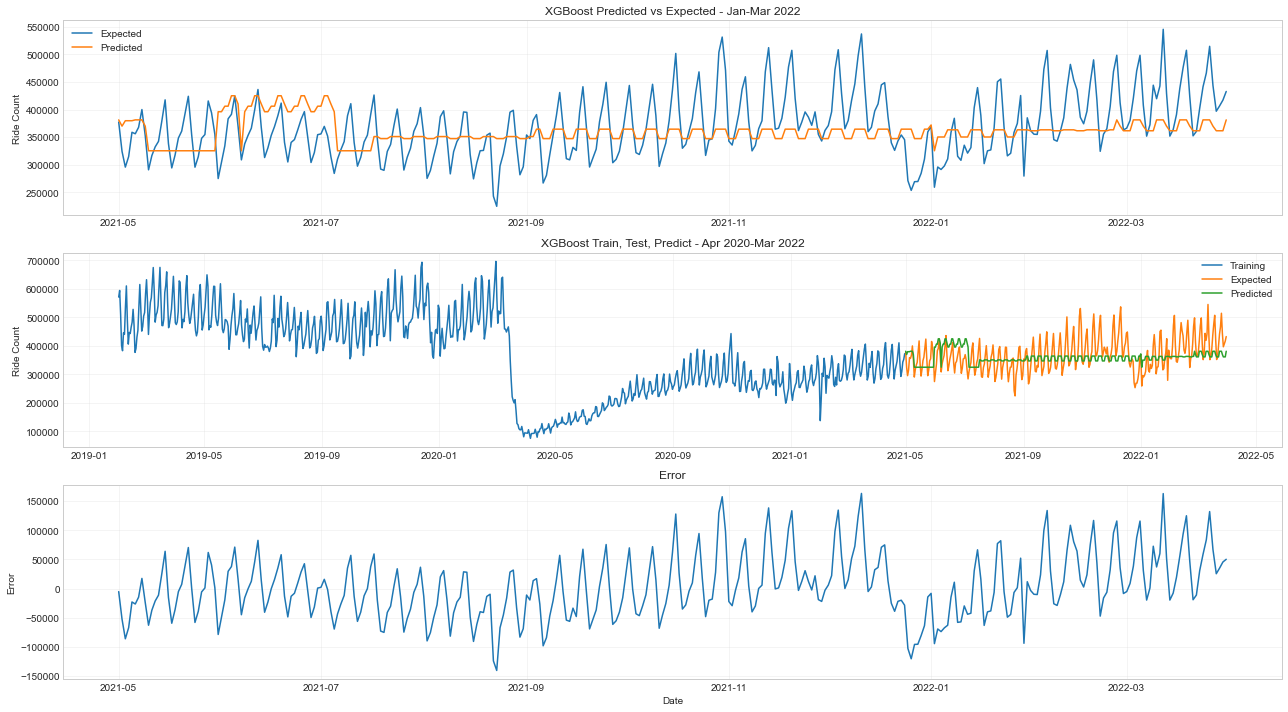

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
        model_1   38032.45   7.75    3.98  0.000069     370507.73   
        model_2   39468.39   7.91   3.291  0.000999     370507.73   
        model_3  205198.04  26.45   3.808   0.00014     370507.73   
        model_4   47045.16  10.34   6.905       0.0     370507.73   
        model_5   44772.84   9.66   6.824       0.0     370507.73   
        model_6   43337.47   9.06   6.487       0.0     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   
        model_1    55134.9  11.04   5.722       0.0     370507.73   
        model_2   55457.54  11.16   5.788       0.0     370507.73   
        model_3   57026.94  11.82   2.923  0.003468     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
        model_6     267818.63     57620.28     33313.48  
prophet control     350029.01     57620.28      51899.0  
        model_1     353562.34     57620.28     52301.35  
        model_2     356359.16     57620.28     53418.19  
        model_3     323071.44     57620.28    220238.15  
        model_4     338952.73     57620.28     60453.77  
        model_5     340980.83     57620.28     54164.35  
        model_6     343042.14     57620.28     51647.76  
xgboost control     367160.06     57620.28      8344.25  
        model_1     351819.16     57620.28      15592.3  
        model_2     351555.12     57620.28     16150.92  
        model_3     360664.22     57620.28     21635.99

In [80]:
xgb_X_train_3 = pd.concat([X_train_scaled, cases_train_scaled], axis=1)
xgb_X_test_3 = pd.concat([X_test_scaled, cases_test_scaled], axis=1)
xgb_3_results = get_xgboost(xgb_X_train_3, xgb_X_test_3, y_train_scaled, y_test_scaled)
get_metrics(xgb_3_results, metrics, 'xgboost', 'model_3').dropna()

#### XGBoost Model 4:  Covid-19, Hospitalizations

***

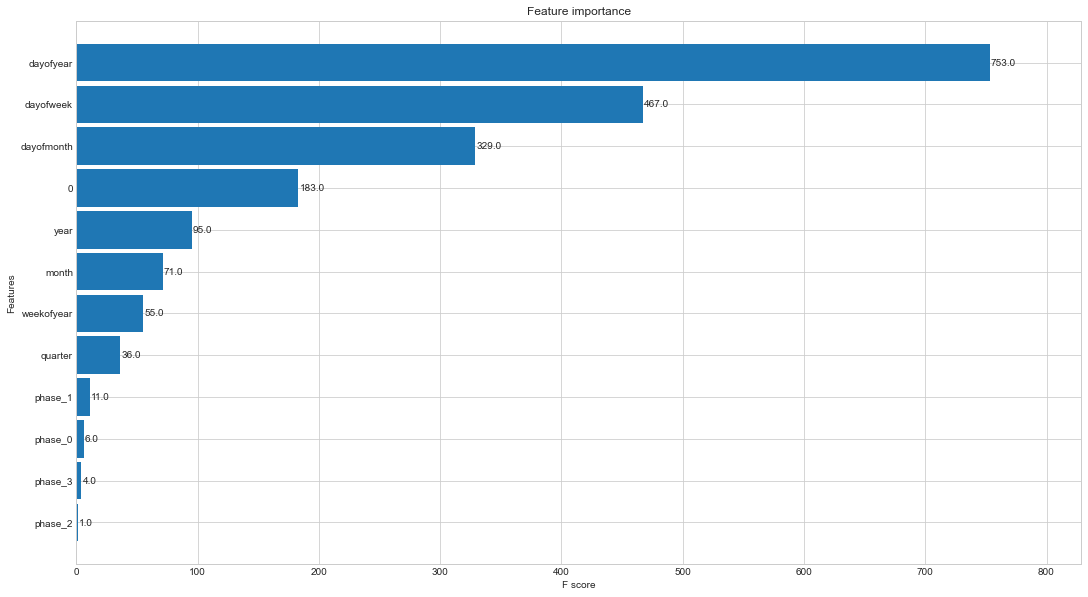

expected     predicted        error
2021-05-01  377323.0  381282.06250  -5194.78125
2021-05-02  324331.0  369900.03125 -52306.31250
2021-05-03  295623.0  379737.65625 -86096.84375

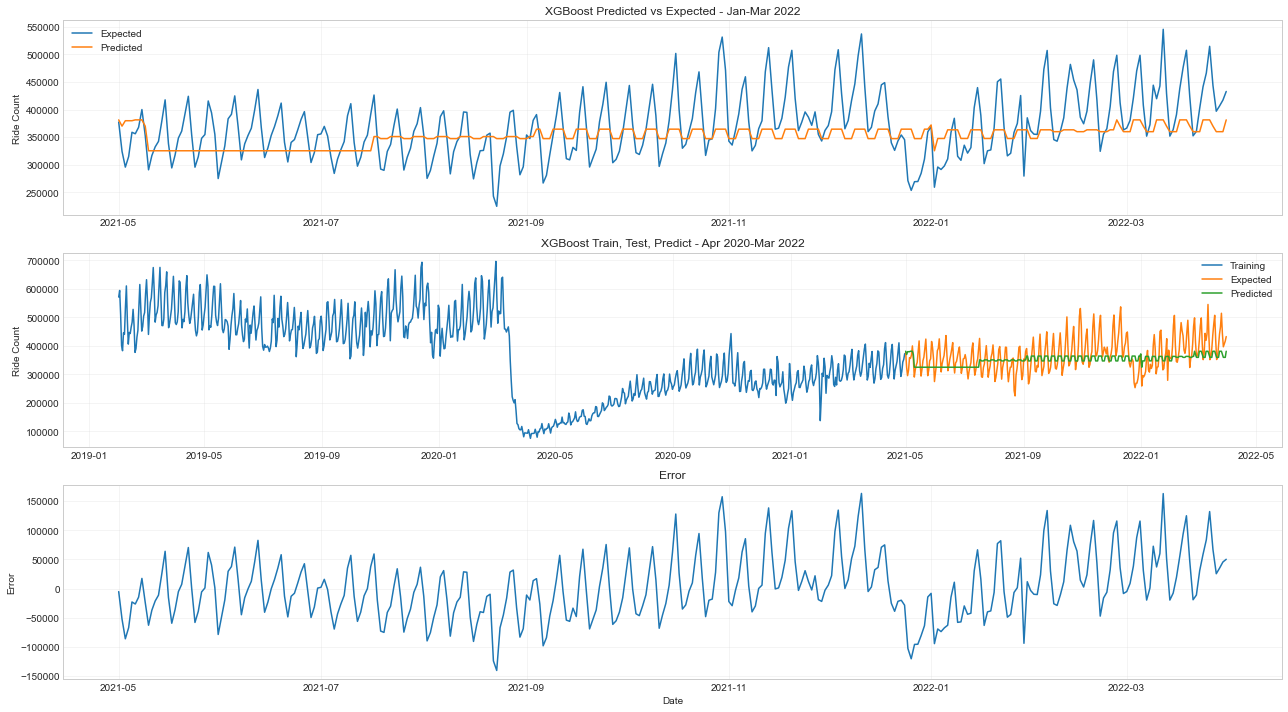

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
        model_1   38032.45   7.75    3.98  0.000069     370507.73   
        model_2   39468.39   7.91   3.291  0.000999     370507.73   
        model_3  205198.04  26.45   3.808   0.00014     370507.73   
        model_4   47045.16  10.34   6.905       0.0     370507.73   
        model_5   44772.84   9.66   6.824       0.0     370507.73   
        model_6   43337.47   9.06   6.487       0.0     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   
        model_1    55134.9  11.04   5.722       0.0     370507.73   
        model_2   55457.54  11.16   5.788       0.0     370507.73   
        model_3   57026.94  11.82   2.923  0.003468     370507.73   
        model_4   55457.54  11.16   5.788       0.0     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
        model_6     267818.63     57620.28     33313.48  
prophet control     350029.01     57620.28      51899.0  
        model_1     353562.34     57620.28     52301.35  
        model_2     356359.16     57620.28     53418.19  
        model_3     323071.44     57620.28    220238.15  
        model_4     338952.73     57620.28     60453.77  
        model_5     340980.83     57620.28     54164.35  
        model_6     343042.14     57620.28     51647.76  
xgboost control     367160.06     57620.28      8344.25  
        model_1     351819.16     57620.28      15592.3  
        model_2     351555.12     57620.28     16150.92  
        model_3     360664.22     57620.28     21635.99  
        model_4     351555.12     57620.28     16150.92

In [81]:
xgb_X_train_4 = pd.concat([X_train_scaled, hosp_train_scaled], axis=1)
xgb_X_test_4 = pd.concat([X_test_scaled, hosp_test_scaled], axis=1)
xgb_4_results = get_xgboost(xgb_X_train_4, xgb_X_test_4, y_train_scaled, y_test_scaled)
get_metrics(xgb_4_results, metrics, 'xgboost', 'model_4').dropna()

#### XGBoost Model 5: Covid-19, Deaths

***

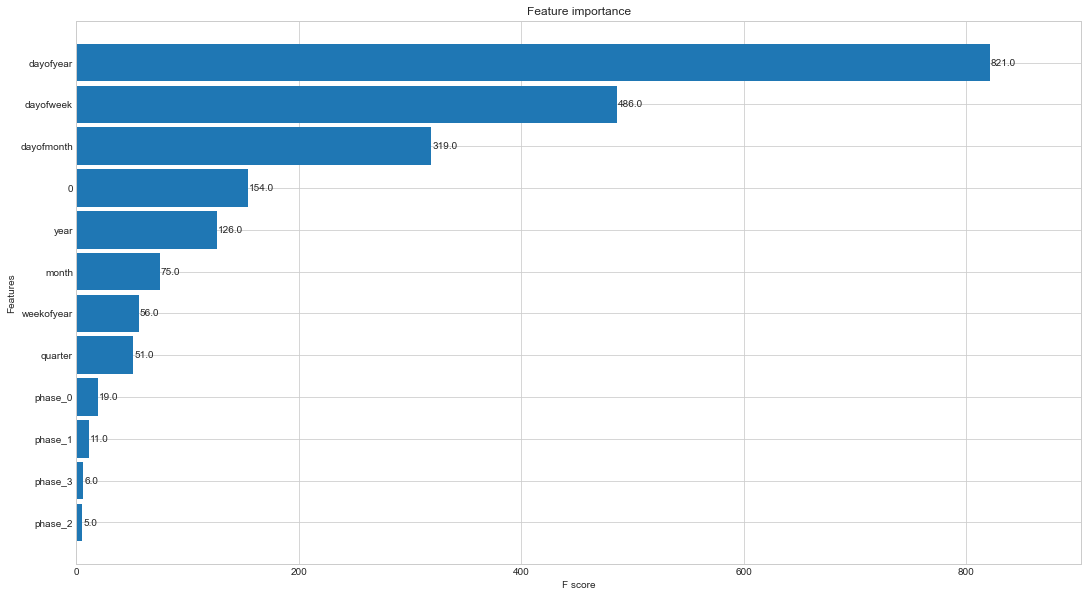

expected     predicted        error
2021-05-01  377323.0  382809.15625  -5194.78125
2021-05-02  324331.0  362313.96875 -52306.31250
2021-05-03  295623.0  360353.46875 -86096.84375

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
        model_1   38032.45   7.75    3.98  0.000069     370507.73   
        model_2   39468.39   7.91   3.291  0.000999     370507.73   
        model_3  205198.04  26.45   3.808   0.00014     370507.73   
        model_4   47045.16  10.34   6.905       0.0     370507.73   
        model_5   44772.84   9.66   6.824       0.0     370507.73   
        model_6   43337.47   9.06   6.487       0.0     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   
        model_1    55134.9  11.04   5.722       0.0     370507.73   
        model_2   55457.54  11.16   5.788       0.0     370507.73   
        model_3   57026.94  11.82   2.923  0.003468     370507.73   
        model_4   55457.54  11.16   5.788       0.0     370507.73   
        model_5   66037.51  13.48  12.201       0.0     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
        model_6     267818.63     57620.28     33313.48  
prophet control     350029.01     57620.28      51899.0  
        model_1     353562.34     57620.28     52301.35  
        model_2     356359.16     57620.28     53418.19  
        model_3     323071.44     57620.28    220238.15  
        model_4     338952.73     57620.28     60453.77  
        model_5     340980.83     57620.28     54164.35  
        model_6     343042.14     57620.28     51647.76  
xgboost control     367160.06     57620.28      8344.25  
        model_1     351819.16     57620.28      15592.3  
        model_2     351555.12     57620.28     16150.92  
        model_3     360664.22     57620.28     21635.99  
        model_4     351555.12     57620.28     16150.92  
        model_5     327584.97     57620.28     28524.84

In [82]:
xgb_X_train_5 = pd.concat([X_train_scaled, death_train_scaled], axis=1)
xgb_X_test_5 = pd.concat([X_test_scaled, death_test_scaled], axis=1)
xgb_5_results = get_xgboost(xgb_X_train_5, xgb_X_test_5, y_train_scaled, y_test_scaled)
get_metrics(xgb_5_results, metrics, 'xgboost', 'model_5').dropna()

#### XGBoost Model 6: Covid-19, Vaccinations
***

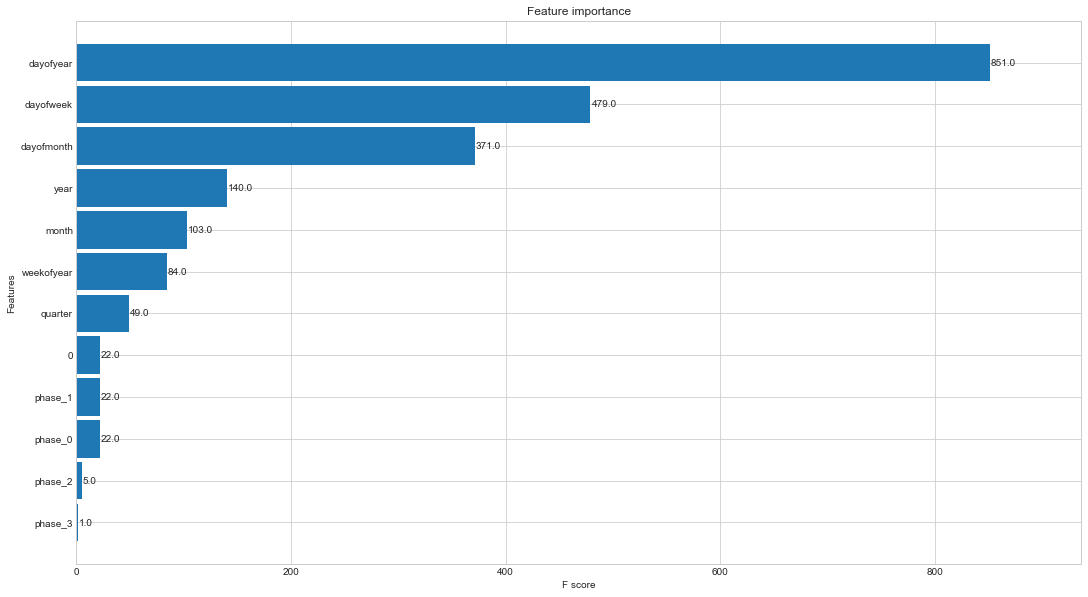

expected     predicted        error
2021-05-01  377323.0  381282.06250  -5194.78125
2021-05-02  324331.0  369900.03125 -52306.31250
2021-05-03  295623.0  359616.40625 -86096.84375

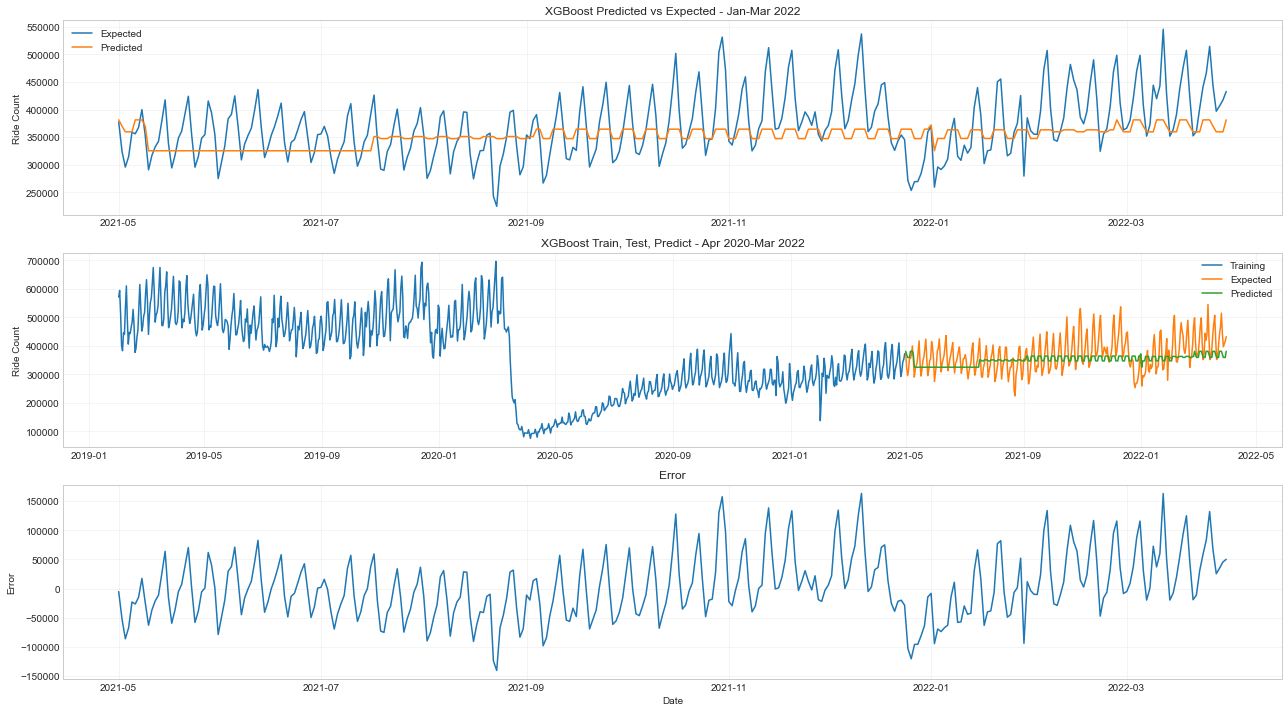

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
        model_1   38032.45   7.75    3.98  0.000069     370507.73   
        model_2   39468.39   7.91   3.291  0.000999     370507.73   
        model_3  205198.04  26.45   3.808   0.00014     370507.73   
        model_4   47045.16  10.34   6.905       0.0     370507.73   
        model_5   44772.84   9.66   6.824       0.0     370507.73   
        model_6   43337.47   9.06   6.487       0.0     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   
        model_1    55134.9  11.04   5.722       0.0     370507.73   
        model_2   55457.54  11.16   5.788       0.0     370507.73   
        model_3   57026.94  11.82   2.923  0.003468     370507.73   
        model_4   55457.54  11.16   5.788       0.0     370507.73   
        model_5   66037.51  13.48  12.201       0.0     370507.73   
        model_6   55311.24  11.11   5.855       0.0     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
        model_6     267818.63     57620.28     33313.48  
prophet control     350029.01     57620.28      51899.0  
        model_1     353562.34     57620.28     52301.35  
        model_2     356359.16     57620.28     53418.19  
        model_3     323071.44     57620.28    220238.15  
        model_4     338952.73     57620.28     60453.77  
        model_5     340980.83     57620.28     54164.35  
        model_6     343042.14     57620.28     51647.76  
xgboost control     367160.06     57620.28      8344.25  
        model_1     351819.16     57620.28      15592.3  
        model_2     351555.12     57620.28     16150.92  
        model_3     360664.22     57620.28     21635.99  
        model_4     351555.12     57620.28     16150.92  
        model_5     327584.97     57620.28     28524.84  
        model_6     351356.03     57620.28     15936.38

In [83]:
xgb_X_train_6 = pd.concat([X_train_scaled, vax_train_scaled], axis=1)
xgb_X_test_6 = pd.concat([X_test_scaled, vax_test_scaled], axis=1)
xgb_6_results = get_xgboost(xgb_X_train_6, xgb_X_test_6, y_train_scaled, y_test_scaled)
get_metrics(xgb_6_results, metrics, 'xgboost', 'model_6').dropna()

In [84]:
metrics.sort_values('rmse')

rmse   mape z_score    pvalue observed_mean  \
prophet model_1   38032.45   7.75    3.98  0.000069     370507.73   
        model_2   39468.39   7.91   3.291  0.000999     370507.73   
        control   39541.93   8.07   4.826  0.000001     370507.73   
        model_6   43337.47   9.06   6.487       0.0     370507.73   
        model_5   44772.84   9.66   6.824       0.0     370507.73   
        model_4   47045.16  10.34   6.905       0.0     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   
        model_1    55134.9  11.04   5.722       0.0     370507.73   
        model_6   55311.24  11.11   5.855       0.0     370507.73   
        model_4   55457.54  11.16   5.788       0.0     370507.73   
        model_2   55457.54  11.16   5.788       0.0     370507.73   
        model_3   57026.94  11.82   2.923  0.003468     370507.73   
sarimax model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
xgboost model_5   66037.51  13.48  12.201       0.0     370507.73   
sarimax model_5   71956.58  13.81  11.744       0.0     370507.73   
        control   73182.06  13.99  12.236       0.0     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
prophet model_3  205198.04  26.45   3.808   0.00014     370507.73   

                forecast_mean observed_std forecast_std  
prophet model_1     353562.34     57620.28     52301.35  
        model_2     356359.16     57620.28     53418.19  
        control     350029.01     57620.28      51899.0  
        model_6     343042.14     57620.28     51647.76  
        model_5     340980.83     57620.28     54164.35  
        model_4     338952.73     57620.28     60453.77  
xgboost control     367160.06     57620.28      8344.25  
        model_1     351819.16     57620.28      15592.3  
        model_6     351356.03     57620.28     15936.38  
        model_4     351555.12     57620.28     16150.92  
        model_2     351555.12     57620.28     16150.92  
        model_3     360664.22     57620.28     21635.99  
sarimax model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
xgboost model_5     327584.97     57620.28     28524.84  
sarimax model_5     330333.46     57620.28     24256.86  
        control     328625.19     57620.28     24349.79  
        model_4     326425.48     57620.28     32312.75  
        model_6     267818.63     57620.28     33313.48  
        model_3     379834.35     57620.28    152884.22  
prophet model_3     323071.44     57620.28    220238.15

In [85]:
metrics.loc[('prophet', 'model_7'),:] = np.nan

Initial log joint probability = -21.9873
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1898.35    0.00128871       171.587      0.7856      0.7856      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       1901.71   9.74135e-05       120.857   8.374e-07       0.001      249  LS failed, Hessian reset 
     199       1902.11    0.00067161       116.175      0.4221      0.4221      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       1902.41   0.000226705       194.915   1.847e-06       0.001      348  LS failed, Hessian reset 
     299       1903.01   0.000607626        191.91   4.699e-06       0.001      517  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1903.32     0.0016373       75.1256           1           1      632 

expected      predicted         error          lower  \
2021-05-01  377323.0  421169.079023 -21923.039512  365160.527365   
2021-05-02  324331.0  351953.952813 -13811.476407  298927.919866   
2021-05-03  295623.0  321573.597464 -12975.298732  269356.752309   

                    upper  
2021-05-01  471713.448939  
2021-05-02  401276.816001  
2021-05-03  374839.814210

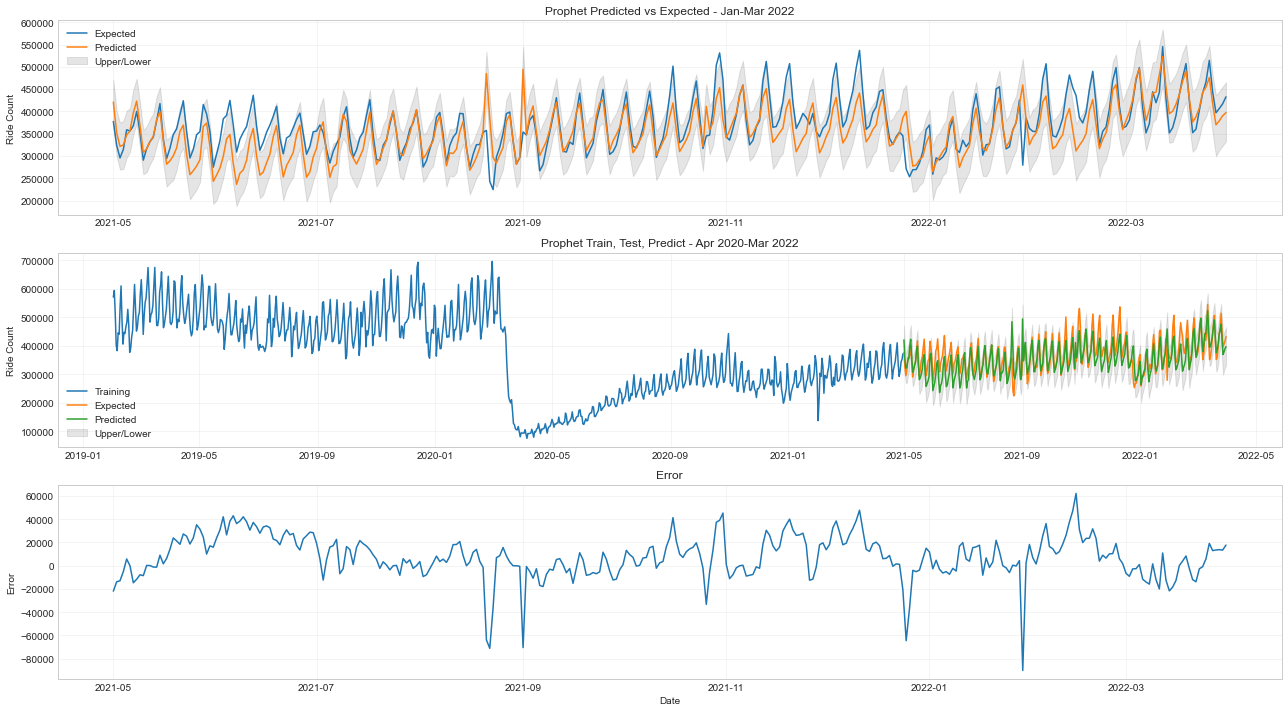

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
        model_1   38032.45   7.75    3.98  0.000069     370507.73   
        model_2   39468.39   7.91   3.291  0.000999     370507.73   
        model_3  205198.04  26.45   3.808   0.00014     370507.73   
        model_4   47045.16  10.34   6.905       0.0     370507.73   
        model_5   44772.84   9.66   6.824       0.0     370507.73   
        model_6   43337.47   9.06   6.487       0.0     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   
        model_1    55134.9  11.04   5.722       0.0     370507.73   
        model_2   55457.54  11.16   5.788       0.0     370507.73   
        model_3   57026.94  11.82   2.923  0.003468     370507.73   
        model_4   55457.54  11.16   5.788       0.0     370507.73   
        model_5   66037.51  13.48  12.201       0.0     370507.73   
        model_6   55311.24  11.11   5.855       0.0     370507.73   
prophet model_7   40106.09   8.02   3.731  0.000191     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
        model_6     267818.63     57620.28     33313.48  
prophet control     350029.01     57620.28      51899.0  
        model_1     353562.34     57620.28     52301.35  
        model_2     356359.16     57620.28     53418.19  
        model_3     323071.44     57620.28    220238.15  
        model_4     338952.73     57620.28     60453.77  
        model_5     340980.83     57620.28     54164.35  
        model_6     343042.14     57620.28     51647.76  
xgboost control     367160.06     57620.28      8344.25  
        model_1     351819.16     57620.28      15592.3  
        model_2     351555.12     57620.28     16150.92  
        model_3     360664.22     57620.28     21635.99  
        model_4     351555.12     57620.28     16150.92  
        model_5     327584.97     57620.28     28524.84  
        model_6     351356.03     57620.28     15936.38  
prophet model_7      354512.8     57620.28     53087.52

In [86]:
temp_prec = pd.concat([temp, prec], axis=1)
temp_prec_train, temp_prec_test = split_train_test(temp_prec, train_stop, test_start)
prophet_7_train = pd.concat([prophet_train, temp_prec_train.reset_index(drop=True)], axis=1)
prophet_7_test = pd.concat([regressors, temp_prec], axis=1).reset_index(drop=True)
prophet_7_results = get_prophet(prophet_7_train, prophet_7_test, prophet_test)
get_metrics(prophet_7_results, metrics, 'prophet', 'model_7').dropna()

In [87]:
metrics.loc[('prophet', 'model_8'),:] = np.nan

In [88]:
vax_temp = pd.concat([vax, temp], axis=1)
vax_temp_train, vax_temp_test = split_train_test(vax_temp, train_stop, test_start)
prophet_8_train = pd.concat([prophet_train, vax_temp_train.reset_index(drop=True)], axis=1)
prophet_8_test = pd.concat([regressors, vax_temp], axis=1).reset_index(drop=True)
prophet_8_results = get_prophet(prophet_8_train, prophet_8_test, prophet_test)
get_metrics(prophet_8_results, metrics, 'prophet', 'model_8').dropna()

Initial log joint probability = -21.9873
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1884.68    0.00497538       251.568      0.8245      0.8245      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1889.91   3.31264e-05       73.3805       0.421       0.421      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1890.57   0.000546863        65.774      0.8828      0.8828      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     383       1890.73   8.90803e-05       107.776   9.006e-07       0.001      494  LS failed, Hessian reset 
     399       1890.74   6.91892e-06       59.5624      0.6151      0.6151      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1890.8   1.40323e-06    

expected      predicted         error          lower  \
2021-05-01  377323.0  413984.796061 -18330.898030  361357.205270   
2021-05-02  324331.0  341854.230154  -8761.615077  286527.219879   
2021-05-03  295623.0  300089.129671  -2233.064835  248245.985482   

                    upper  
2021-05-01  462240.832084  
2021-05-02  395648.009101  
2021-05-03  353151.137119

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
        model_1   38032.45   7.75    3.98  0.000069     370507.73   
        model_2   39468.39   7.91   3.291  0.000999     370507.73   
        model_3  205198.04  26.45   3.808   0.00014     370507.73   
        model_4   47045.16  10.34   6.905       0.0     370507.73   
        model_5   44772.84   9.66   6.824       0.0     370507.73   
        model_6   43337.47   9.06   6.487       0.0     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   
        model_1    55134.9  11.04   5.722       0.0     370507.73   
        model_2   55457.54  11.16   5.788       0.0     370507.73   
        model_3   57026.94  11.82   2.923  0.003468     370507.73   
        model_4   55457.54  11.16   5.788       0.0     370507.73   
        model_5   66037.51  13.48  12.201       0.0     370507.73   
        model_6   55311.24  11.11   5.855       0.0     370507.73   
prophet model_7   40106.09   8.02   3.731  0.000191     370507.73   
        model_8    46238.8   9.82   7.566       0.0     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
        model_6     267818.63     57620.28     33313.48  
prophet control     350029.01     57620.28      51899.0  
        model_1     353562.34     57620.28     52301.35  
        model_2     356359.16     57620.28     53418.19  
        model_3     323071.44     57620.28    220238.15  
        model_4     338952.73     57620.28     60453.77  
        model_5     340980.83     57620.28     54164.35  
        model_6     343042.14     57620.28     51647.76  
xgboost control     367160.06     57620.28      8344.25  
        model_1     351819.16     57620.28      15592.3  
        model_2     351555.12     57620.28     16150.92  
        model_3     360664.22     57620.28     21635.99  
        model_4     351555.12     57620.28     16150.92  
        model_5     327584.97     57620.28     28524.84  
        model_6     351356.03     57620.28     15936.38  
prophet model_7      354512.8     57620.28     53087.52  
        model_8     338595.03     57620.28     51199.91

In [89]:
metrics.loc[('prophet', 'model_9'),:] = np.nan

Initial log joint probability = -21.9873
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1897.54     0.0139108       368.011           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1901.8      0.001876       92.4218           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       1902.49   0.000476005       193.994   2.733e-06       0.001      322  LS failed, Hessian reset 
     299       1903.14   0.000304025       55.9129      0.3643           1      402   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1903.23    7.9785e-06       65.7281           1           1      537   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1903.27   1.86289e-05    

expected      predicted         error          lower  \
2021-05-01  377323.0  412129.839386 -17403.419693  361691.730988   
2021-05-02  324331.0  338192.200938  -6930.600469  287183.676498   
2021-05-03  295623.0  309394.304976  -6885.652488  256223.879077   

                    upper  
2021-05-01  462696.505912  
2021-05-02  389065.432018  
2021-05-03  360842.902551

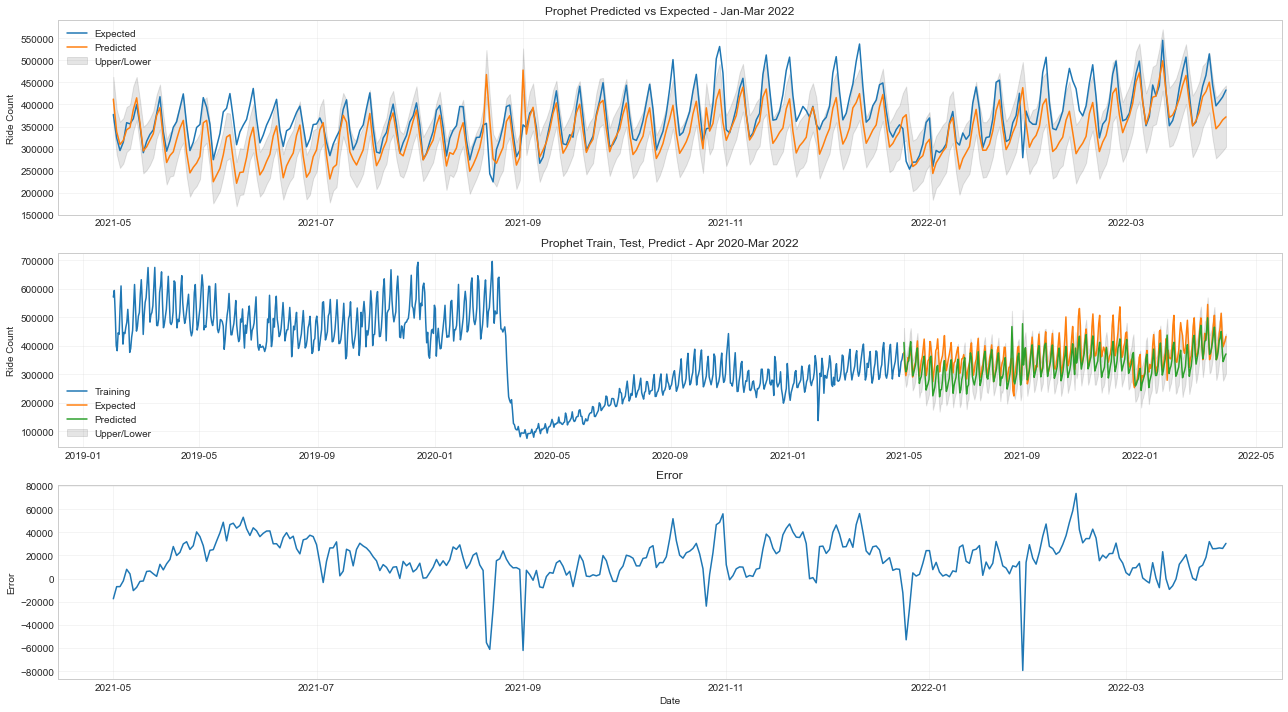

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
        model_1   38032.45   7.75    3.98  0.000069     370507.73   
        model_2   39468.39   7.91   3.291  0.000999     370507.73   
        model_3  205198.04  26.45   3.808   0.00014     370507.73   
        model_4   47045.16  10.34   6.905       0.0     370507.73   
        model_5   44772.84   9.66   6.824       0.0     370507.73   
        model_6   43337.47   9.06   6.487       0.0     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   
        model_1    55134.9  11.04   5.722       0.0     370507.73   
        model_2   55457.54  11.16   5.788       0.0     370507.73   
        model_3   57026.94  11.82   2.923  0.003468     370507.73   
        model_4   55457.54  11.16   5.788       0.0     370507.73   
        model_5   66037.51  13.48  12.201       0.0     370507.73   
        model_6   55311.24  11.11   5.855       0.0     370507.73   
prophet model_7   40106.09   8.02   3.731  0.000191     370507.73   
        model_8    46238.8   9.82   7.566       0.0     370507.73   
        model_9   49951.93  10.83   8.068       0.0     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
        model_6     267818.63     57620.28     33313.48  
prophet control     350029.01     57620.28      51899.0  
        model_1     353562.34     57620.28     52301.35  
        model_2     356359.16     57620.28     53418.19  
        model_3     323071.44     57620.28    220238.15  
        model_4     338952.73     57620.28     60453.77  
        model_5     340980.83     57620.28     54164.35  
        model_6     343042.14     57620.28     51647.76  
xgboost control     367160.06     57620.28      8344.25  
        model_1     351819.16     57620.28      15592.3  
        model_2     351555.12     57620.28     16150.92  
        model_3     360664.22     57620.28     21635.99  
        model_4     351555.12     57620.28     16150.92  
        model_5     327584.97     57620.28     28524.84  
        model_6     351356.03     57620.28     15936.38  
prophet model_7      354512.8     57620.28     53087.52  
        model_8     338595.03     57620.28     51199.91  
        model_9     336221.42     57620.28      52078.6

In [90]:
vax_temp_prec = pd.concat([vax_temp, prec], axis=1)
vax_temp_prec_train, vax_temp_prec_test = split_train_test(vax_temp_prec, train_stop, test_start)
prophet_9_train = pd.concat([prophet_train, vax_temp_prec_train.reset_index(drop=True)], axis=1)
prophet_9_test = pd.concat([regressors, vax_temp_prec], axis=1).reset_index(drop=True)
prophet_9_results = get_prophet(prophet_9_train, prophet_9_test, prophet_test)
get_metrics(prophet_9_results, metrics, 'prophet', 'model_9').dropna()

>**Research Question 4:**
>
>What is the forecasted growth of rideshare demand for each company?
***

In [91]:
metrics.sort_values('rmse')

rmse   mape z_score    pvalue observed_mean  \
prophet model_1   38032.45   7.75    3.98  0.000069     370507.73   
        model_2   39468.39   7.91   3.291  0.000999     370507.73   
        control   39541.93   8.07   4.826  0.000001     370507.73   
        model_7   40106.09   8.02   3.731  0.000191     370507.73   
        model_6   43337.47   9.06   6.487       0.0     370507.73   
        model_5   44772.84   9.66   6.824       0.0     370507.73   
        model_8    46238.8   9.82   7.566       0.0     370507.73   
        model_4   47045.16  10.34   6.905       0.0     370507.73   
        model_9   49951.93  10.83   8.068       0.0     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   
        model_1    55134.9  11.04   5.722       0.0     370507.73   
        model_6   55311.24  11.11   5.855       0.0     370507.73   
        model_2   55457.54  11.16   5.788       0.0     370507.73   
        model_4   55457.54  11.16   5.788       0.0     370507.73   
        model_3   57026.94  11.82   2.923  0.003468     370507.73   
sarimax model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
xgboost model_5   66037.51  13.48  12.201       0.0     370507.73   
sarimax model_5   71956.58  13.81  11.744       0.0     370507.73   
        control   73182.06  13.99  12.236       0.0     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
prophet model_3  205198.04  26.45   3.808   0.00014     370507.73   

                forecast_mean observed_std forecast_std  
prophet model_1     353562.34     57620.28     52301.35  
        model_2     356359.16     57620.28     53418.19  
        control     350029.01     57620.28      51899.0  
        model_7      354512.8     57620.28     53087.52  
        model_6     343042.14     57620.28     51647.76  
        model_5     340980.83     57620.28     54164.35  
        model_8     338595.03     57620.28     51199.91  
        model_4     338952.73     57620.28     60453.77  
        model_9     336221.42     57620.28      52078.6  
xgboost control     367160.06     57620.28      8344.25  
        model_1     351819.16     57620.28      15592.3  
        model_6     351356.03     57620.28     15936.38  
        model_2     351555.12     57620.28     16150.92  
        model_4     351555.12     57620.28     16150.92  
        model_3     360664.22     57620.28     21635.99  
sarimax model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
xgboost model_5     327584.97     57620.28     28524.84  
sarimax model_5     330333.46     57620.28     24256.86  
        control     328625.19     57620.28     24349.79  
        model_4     326425.48     57620.28     32312.75  
        model_6     267818.63     57620.28     33313.48  
        model_3     379834.35     57620.28    152884.22  
prophet model_3     323071.44     57620.28    220238.15

## Forecast Demand
***

In [92]:
def get_pred(info, regs=False, regressors=None, conf_int=False):
    train, future = (info)
    m= Prophet(daily_seasonality=7)
    if regs == True:
        for col in regressors.columns:
            m.add_regressor(col)
    m.fit(train)
    fcast = m.predict(future)
    if conf_int == True:
        fcast = fcast[
            ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
        ].set_index('ds')
    else:
        fcast = fcast[['ds', 'yhat']].set_index('ds')
    return fcast

In [93]:
observed_data = pd.DataFrame(index = np.arange(np.datetime64('2019-02-01'), np.datetime64('2022-07-01')))

In [94]:
uber_data = pd.concat([observed_data, uber], axis=1)

In [95]:
uber_X, uber_y = get_Xy_features(uber_data)

In [96]:
uber_X.phase_0.fillna(0, inplace=True)
uber_X.phase_1.fillna(0, inplace=True)
uber_X.phase_2.fillna(0, inplace=True)
uber_X.phase_3.fillna(1, inplace=True)

In [97]:
uber_X.holiday[['2022/05/30', '2022/06/19', '2022/06/20']] = 1

### Forecast Temperature
***

In [98]:
temp_y = pd.concat([observed_data, temp], axis=1)

In [99]:
temp_y

temp
2019-02-01  16.0
2019-02-02  25.0
2019-02-03  43.0
2019-02-04  51.0
2019-02-05  54.5
...          ...
2022-06-26   NaN
2022-06-27   NaN
2022-06-28   NaN
2022-06-29   NaN
2022-06-30   NaN

[1246 rows x 1 columns]

In [100]:
def get_prophet_df(df):
    prophet_df = df.reset_index()
    prophet_df.columns = ['ds', 'y']
    return prophet_df

In [101]:
prophet_temp = get_prophet_df(temp_y)

In [102]:
prophet_temp.head(3)

ds     y
0 2019-02-01  16.0
1 2019-02-02  25.0
2 2019-02-03  43.0

In [103]:
stop, start = '2022/03/31', '2022/04/01'

In [104]:
prophet_temp_train = prophet_temp.loc[:prophet_temp[prophet_temp.ds == stop].index.values[0]]

In [105]:
temp_preds = get_pred((prophet_temp_train, prophet_temp))

Initial log joint probability = -64.6869
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2383.19    0.00167304       420.076      0.2489      0.6906      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2387.58   0.000728185       77.3602      0.7932      0.7932      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       2387.95   0.000367009       239.761   3.036e-06       0.001      404  LS failed, Hessian reset 
     299       2388.22   7.65291e-06       93.9031           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       2388.23   5.70335e-08       89.6934      0.2395           1      550   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [106]:
temp_preds[:stop] = temp_y[:stop]

In [107]:
temp_preds.columns = ['temp']

In [108]:
temp_preds

temp
ds                   
2019-02-01  16.000000
2019-02-02  25.000000
2019-02-03  43.000000
2019-02-04  51.000000
2019-02-05  54.500000
...               ...
2022-06-26  75.253590
2022-06-27  76.145305
2022-06-28  76.549649
2022-06-29  77.112359
2022-06-30  77.703563

[1246 rows x 1 columns]

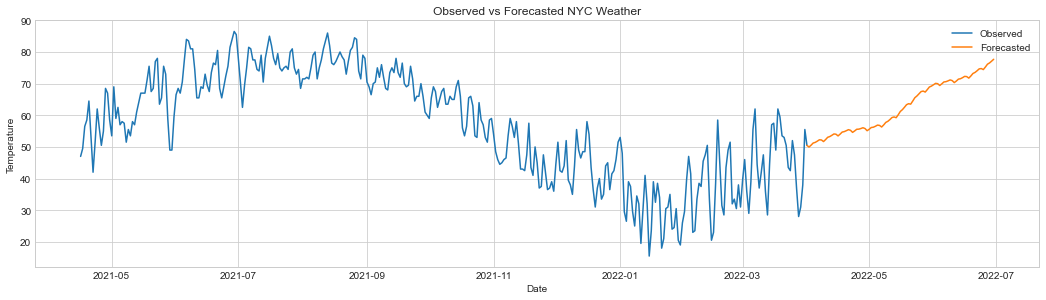

In [109]:
plt.subplot(211)
plt.plot(temp_preds['2021/04/16':'2022/04/01'], label='Observed')
plt.plot(temp_preds['2022/04/01':], label='Forecasted')
plt.title('Observed vs Forecasted NYC Weather')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

### Forecast Rideshare Demand
***

In [110]:
prophet_df = get_prophet_df(uber_y)

In [111]:
prophet_exog = pd.concat([uber_X, temp_preds], axis=1)

In [112]:
prophet_df = pd.concat([prophet_df, prophet_exog.reset_index(drop=True)], axis=1)

In [113]:
prophet_df.head(3)

ds         y  dayofweek  quarter  month  year  dayofyear  \
0 2019-02-01  571535.0          4        1      2  2019         32   
1 2019-02-02  594632.0          5        1      2  2019         33   
2 2019-02-03  510417.0          6        1      2  2019         34   

   dayofmonth  weekofyear  phase_0  phase_1  phase_2  phase_3  holiday  temp  
0           1           5      1.0      0.0      0.0      0.0        0  16.0  
1           2           5      1.0      0.0      0.0      0.0        0  25.0  
2           3           5      1.0      0.0      0.0      0.0        0  43.0

In [114]:
train = prophet_df.loc[:prophet_df[prophet_df.ds == stop].index.values[0]]
test = prophet_df

In [115]:
results = get_pred((train, test), regs=True, regressors=prophet_exog, conf_int=True)

Initial log joint probability = -38.5714
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2724.99    0.00503752       326.566           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2733.7   0.000819324       101.643       2.444      0.2444      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       2735.77   0.000125862       197.644    4.17e-07       0.001      364  LS failed, Hessian reset 
     299       2736.62    0.00203838       143.036           1           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        2738.6   0.000861321       139.656      0.2823           1      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2738.98   7.56924e-05    

In [116]:
results = np.round(pd.concat([results, test[['ds', 'temp']].set_index('ds', drop=True)], axis=1), 2)

In [117]:
results

yhat  yhat_lower  yhat_upper   temp
ds                                                  
2019-02-01  561769.07   513463.68   610497.87  16.00
2019-02-02  577989.45   527134.19   629702.33  25.00
2019-02-03  507049.19   457140.36   555611.47  43.00
2019-02-04  451584.70   401603.85   499914.07  51.00
2019-02-05  460378.62   412543.74   508413.43  54.50
...               ...         ...         ...    ...
2022-06-26  373175.56   326319.78   422466.77  75.25
2022-06-27  322233.65   272896.41   372380.95  76.15
2022-06-28  334038.86   284630.89   379166.09  76.55
2022-06-29  353806.69   303915.82   404456.54  77.11
2022-06-30  372548.24   326114.23   421695.20  77.70

[1246 rows x 4 columns]

In [118]:
metrics

rmse   mape z_score    pvalue observed_mean  \
sarimax control   73182.06  13.99  12.236       0.0     370507.73   
        model_1    60777.4  11.59   9.228       0.0     370507.73   
        model_2   62094.37  12.21    7.03       0.0     370507.73   
        model_3  175354.19  27.25  -1.043  0.296827     370507.73   
        model_4   74231.48  14.73  12.195       0.0     370507.73   
        model_5   71956.58  13.81  11.744       0.0     370507.73   
        model_6  121529.67  26.38  28.197       0.0     370507.73   
prophet control   39541.93   8.07   4.826  0.000001     370507.73   
        model_1   38032.45   7.75    3.98  0.000069     370507.73   
        model_2   39468.39   7.91   3.291  0.000999     370507.73   
        model_3  205198.04  26.45   3.808   0.00014     370507.73   
        model_4   47045.16  10.34   6.905       0.0     370507.73   
        model_5   44772.84   9.66   6.824       0.0     370507.73   
        model_6   43337.47   9.06   6.487       0.0     370507.73   
xgboost control   54352.91   11.5   1.051  0.293268     370507.73   
        model_1    55134.9  11.04   5.722       0.0     370507.73   
        model_2   55457.54  11.16   5.788       0.0     370507.73   
        model_3   57026.94  11.82   2.923  0.003468     370507.73   
        model_4   55457.54  11.16   5.788       0.0     370507.73   
        model_5   66037.51  13.48  12.201       0.0     370507.73   
        model_6   55311.24  11.11   5.855       0.0     370507.73   
prophet model_7   40106.09   8.02   3.731  0.000191     370507.73   
        model_8    46238.8   9.82   7.566       0.0     370507.73   
        model_9   49951.93  10.83   8.068       0.0     370507.73   

                forecast_mean observed_std forecast_std  
sarimax control     328625.19     57620.28     24349.79  
        model_1     339807.68     57620.28     19399.39  
        model_2     346687.41     57620.28     22691.23  
        model_3     379834.35     57620.28    152884.22  
        model_4     326425.48     57620.28     32312.75  
        model_5     330333.46     57620.28     24256.86  
        model_6     267818.63     57620.28     33313.48  
prophet control     350029.01     57620.28      51899.0  
        model_1     353562.34     57620.28     52301.35  
        model_2     356359.16     57620.28     53418.19  
        model_3     323071.44     57620.28    220238.15  
        model_4     338952.73     57620.28     60453.77  
        model_5     340980.83     57620.28     54164.35  
        model_6     343042.14     57620.28     51647.76  
xgboost control     367160.06     57620.28      8344.25  
        model_1     351819.16     57620.28      15592.3  
        model_2     351555.12     57620.28     16150.92  
        model_3     360664.22     57620.28     21635.99  
        model_4     351555.12     57620.28     16150.92  
        model_5     327584.97     57620.28     28524.84  
        model_6     351356.03     57620.28     15936.38  
prophet model_7      354512.8     57620.28     53087.52  
        model_8     338595.03     57620.28     51199.91  
        model_9     336221.42     57620.28      52078.6

In [119]:
z_test = ztest(y, results.yhat['2022/04/01':])
metrics.loc[('forecast', 'forecast'),:] = np.round([
    np.nan,
    np.nan,
    z_test[0][0],
    z_test[1][0],
    y.uber.mean(),
    results.yhat.mean(),
    np.std(y.uber),
    np.std(results.yhat)
], 2)

In [120]:
plt.subplot(211)
plt.plot(results.yhat['2021/04/16':'2022/04/01'], label='Observed')
plt.plot(results.yhat['2022/04/01':], label='Forecasted')
plt.title('Observed vs Forecasted Rideshare Demand')
plt.xlabel('Date')
plt.ylabel('Ride Count')
plt.legend()
plt.show()

In [121]:
metrics

rmse   mape z_score    pvalue observed_mean  \
sarimax  control    73182.06  13.99  12.236       0.0     370507.73   
         model_1     60777.4  11.59   9.228       0.0     370507.73   
         model_2    62094.37  12.21    7.03       0.0     370507.73   
         model_3   175354.19  27.25  -1.043  0.296827     370507.73   
         model_4    74231.48  14.73  12.195       0.0     370507.73   
         model_5    71956.58  13.81  11.744       0.0     370507.73   
         model_6   121529.67  26.38  28.197       0.0     370507.73   
prophet  control    39541.93   8.07   4.826  0.000001     370507.73   
         model_1    38032.45   7.75    3.98  0.000069     370507.73   
         model_2    39468.39   7.91   3.291  0.000999     370507.73   
         model_3   205198.04  26.45   3.808   0.00014     370507.73   
         model_4    47045.16  10.34   6.905       0.0     370507.73   
         model_5    44772.84   9.66   6.824       0.0     370507.73   
         model_6    43337.47   9.06   6.487       0.0     370507.73   
xgboost  control    54352.91   11.5   1.051  0.293268     370507.73   
         model_1     55134.9  11.04   5.722       0.0     370507.73   
         model_2    55457.54  11.16   5.788       0.0     370507.73   
         model_3    57026.94  11.82   2.923  0.003468     370507.73   
         model_4    55457.54  11.16   5.788       0.0     370507.73   
         model_5    66037.51  13.48  12.201       0.0     370507.73   
         model_6    55311.24  11.11   5.855       0.0     370507.73   
prophet  model_7    40106.09   8.02   3.731  0.000191     370507.73   
         model_8     46238.8   9.82   7.566       0.0     370507.73   
         model_9    49951.93  10.83   8.068       0.0     370507.73   
forecast forecast        NaN    NaN   -0.92      0.36      371898.5   

                  forecast_mean observed_std forecast_std  
sarimax  control      328625.19     57620.28     24349.79  
         model_1      339807.68     57620.28     19399.39  
         model_2      346687.41     57620.28     22691.23  
         model_3      379834.35     57620.28    152884.22  
         model_4      326425.48     57620.28     32312.75  
         model_5      330333.46     57620.28     24256.86  
         model_6      267818.63     57620.28     33313.48  
prophet  control      350029.01     57620.28      51899.0  
         model_1      353562.34     57620.28     52301.35  
         model_2      356359.16     57620.28     53418.19  
         model_3      323071.44     57620.28    220238.15  
         model_4      338952.73     57620.28     60453.77  
         model_5      340980.83     57620.28     54164.35  
         model_6      343042.14     57620.28     51647.76  
xgboost  control      367160.06     57620.28      8344.25  
         model_1      351819.16     57620.28      15592.3  
         model_2      351555.12     57620.28     16150.92  
         model_3      360664.22     57620.28     21635.99  
         model_4      351555.12     57620.28     16150.92  
         model_5      327584.97     57620.28     28524.84  
         model_6      351356.03     57620.28     15936.38  
prophet  model_7       354512.8     57620.28     53087.52  
         model_8      338595.03     57620.28     51199.91  
         model_9      336221.42     57620.28      52078.6  
forecast forecast     372782.25    125370.79    115201.85

In [122]:
results.to_parquet('data/uber_forecast.parquet')

In [123]:
metrics.to_parquet('data/uber_model_metrics.parquet')